# Read Data

In [53]:
import pandas as pd
import itertools
import re
import matplotlib.pyplot as plt
import nltk
from transformers import pipeline
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import statsmodels.api as sm

In [2]:
df = pd.read_csv('data/final_v2.csv')
ecb_ir = pd.read_csv('data/ECB_data.csv')
fed_ir = pd.read_csv('data/FEDFUNDS.csv')

# Creating Sentiments

In [3]:
# Defining the aspects of monetary policy
aspects = {
    "inflation": ["inflation", "price stability", "CPI", "deflation"],
    "interest_rates": ["interest rate", "monetary policy", "tightening", "rate hike", "rate cut"],
    "labor_market": ["employment", "unemployment", "jobs", "labor"],
    "financial_stability": ["financial stability", "banking", "credit", "liquidity"],
    "housing": ["housing", "real estate", "mortgage", "home"],
    "epidemic": ["COVID", "pandemic", "virus", "health"]
}


In [4]:
# Extract all the keywords from the aspects
keywords = list(itertools.chain.from_iterable(aspects.values()))

# Counting the words
keyword_counts = {keyword: df['clean_text'].str.count(keyword, flags=re.IGNORECASE).sum() for keyword in keywords}
print(keyword_counts)


{'inflation': np.float64(44784.0), 'price stability': np.float64(10659.0), 'CPI': np.float64(406.0), 'deflation': np.float64(1307.0), 'interest rate': np.float64(14924.0), 'monetary policy': np.float64(29350.0), 'tightening': np.float64(2123.0), 'rate hike': np.float64(226.0), 'rate cut': np.float64(322.0), 'employment': np.float64(13759.0), 'unemployment': np.float64(6369.0), 'jobs': np.float64(2791.0), 'labor': np.float64(7753.0), 'financial stability': np.float64(7212.0), 'banking': np.float64(19655.0), 'credit': np.float64(21211.0), 'liquidity': np.float64(13808.0), 'housing': np.float64(4423.0), 'real estate': np.float64(1248.0), 'mortgage': np.float64(6875.0), 'home': np.float64(5234.0), 'COVID': np.float64(916.0), 'pandemic': np.float64(3691.0), 'virus': np.float64(498.0), 'health': np.float64(2436.0)}


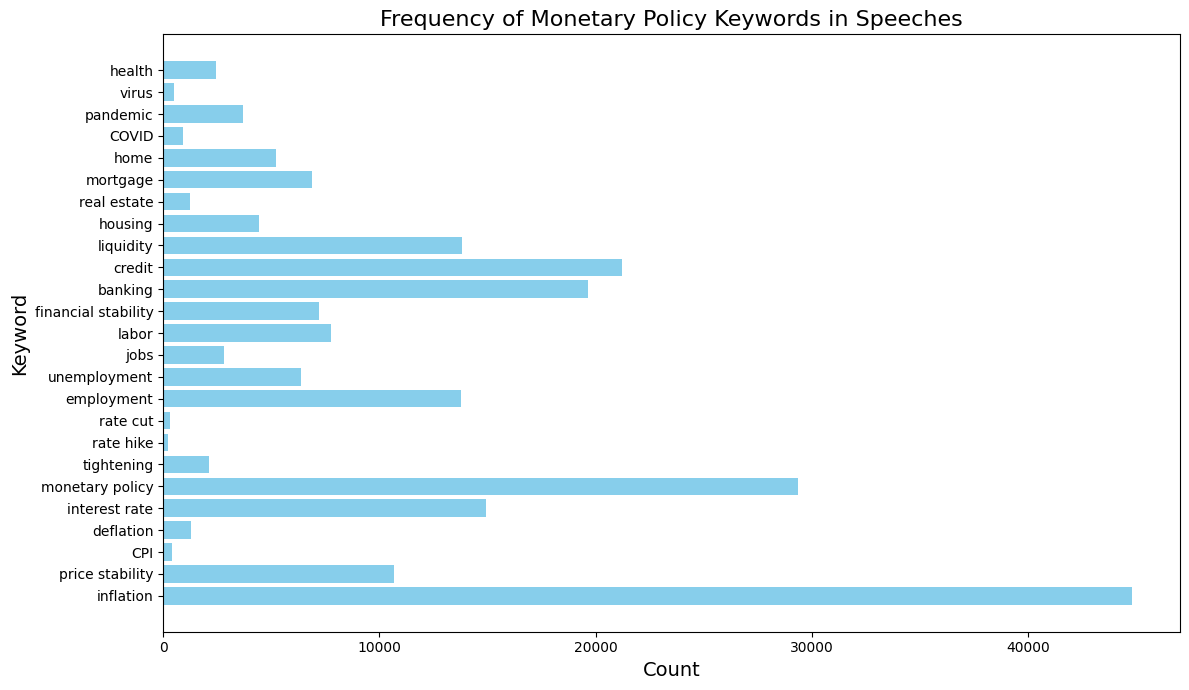

In [5]:
plt.figure(figsize=(12, 7))
plt.barh(list(keyword_counts.keys()), list(keyword_counts.values()), color='skyblue')
plt.xlabel('Count', fontsize=14)
plt.ylabel('Keyword', fontsize=14)
plt.title('Frequency of Monetary Policy Keywords in Speeches', fontsize=16)
plt.tight_layout()
plt.show()

In [6]:
# loading the Sentiment models
sentiment_model = pipeline("sentiment-analysis", model="ProsusAI/finbert")


results = []

# Go through each speech
for idx, speech in df['clean_text'].items():
    if pd.isna(speech) or not isinstance(speech, str):
        continue  

    sentences = sent_tokenize(speech)
    

    aspect_sentiments = {aspect: "Never mentioned" for aspect in aspects}
    aspect_scores = {}

    # look for keywords in each sentence
    for sentence in sentences:
        sentence_lower = sentence.lower()
        for aspect, keywords in aspects.items():
            if any(keyword.lower() in sentence_lower for keyword in keywords):
                sentiment_result = sentiment_model(sentence)[0]
                label = sentiment_result["label"].capitalize()  # z. B. Positive, Negative, Neutral
                score = sentiment_result["score"]

                if (aspect not in aspect_scores) or (score > aspect_scores[aspect]):
                    aspect_sentiments[aspect] = label
                    aspect_scores[aspect] = score

    results.append({
        "speech_id": idx,
        "speech": speech.strip(),
        **{f"sentiment_{k}": v for k, v in aspect_sentiments.items()}
    })

df_sentiment = pd.DataFrame(results)
print(df_sentiment.head())


Device set to use mps:0


KeyboardInterrupt: 

In [ ]:
# Save the DataFrame to a CSV file
#df_sentiment.to_csv('data/cleaned_sentiment_data.csv', index=False)
df_sentiment = pd.read_csv('data/cleaned_sentiment_data.csv')

# Plotting Sentiment Distribution

In [7]:
df_sentiment.head(5)

,date,title,description,text,author,country,clean_text,current_rate,next_rate,next_rate_date,...,days_to_next_decision,quarter,year,role,sentiment_inflation,sentiment_interest_rate,sentiment_labor_market,sentiment_financial_stability,sentiment_housing,sentiment_epidemic
0,1999-01-14 00:00:00,Mr Duisenberg discusses the arrival of the eur...,Speech by the President of the European Centra...,Mr Duisenberg discusses the arrival of the eur...,Willem F Duisenberg,Euro area,Speech by the President of the European Centra...,3.00,2.50,1999-04-09,...,85.0,1,1999,president,Negative,Negative,Positive,Positive,Never mentioned,Never mentioned
1,1999-01-15 00:00:00,Mr Ferguson expresses his views on monetary po...,"Remarks by Mr Roger W. Ferguson, Jr., a member...",Mr Ferguson expresses his views on monetary po...,Roger W Ferguson,United States,"Remarks by Mr Roger W. Ferguson, Jr., a member...",4.63,4.76,1999-02-01,...,17.0,1,1999,governor,Negative,Neutral,Negative,Neutral,Never mentioned,Neutral
2,1999-01-18 00:00:00,Mr Duisenberg's opening statement at the Europ...,Introductory statement by the President of the...,Mr Duisenberg's opening statement at the Europ...,Willem F Duisenberg,Euro area,Introductory statement by the President of the...,3.00,2.50,1999-04-09,...,81.0,1,1999,president,Negative,Negative,Positive,Neutral,Never mentioned,Never mentioned
3,1999-01-20 00:00:00,Mr Greenspan testifies on the state of the US ...,Testimony of the Chairman of the Board of Gove...,Mr Greenspan testifies on the state of the US ...,Alan Greenspan,United States,Testimony of the Chairman of the Board of Gove...,4.63,4.76,1999-02-01,...,12.0,1,1999,chair,Positive,Neutral,Negative,Negative,Never mentioned,Never mentioned
4,1999-01-21 00:00:00,Mr McDonough focuses on the importance of risk...,Remarks by the President of the Federal Reserv...,Mr McDonough focuses on the importance of risk...,William J McDonough,United States,Remarks by the President of the Federal Reserv...,4.63,4.76,1999-02-01,...,11.0,1,1999,president,Never mentioned,Never mentioned,Never mentioned,Negative,Positive,Neutral


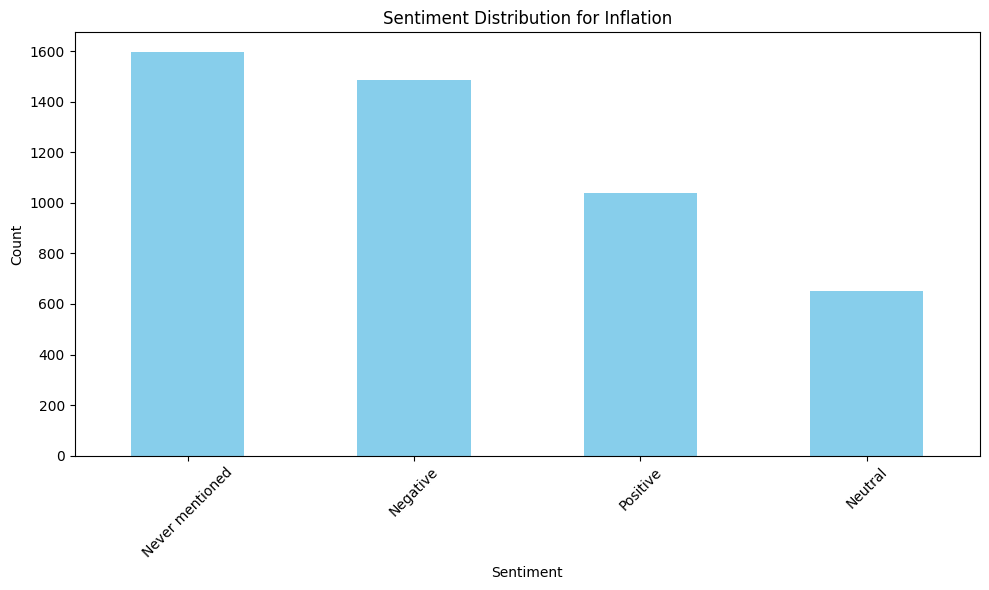

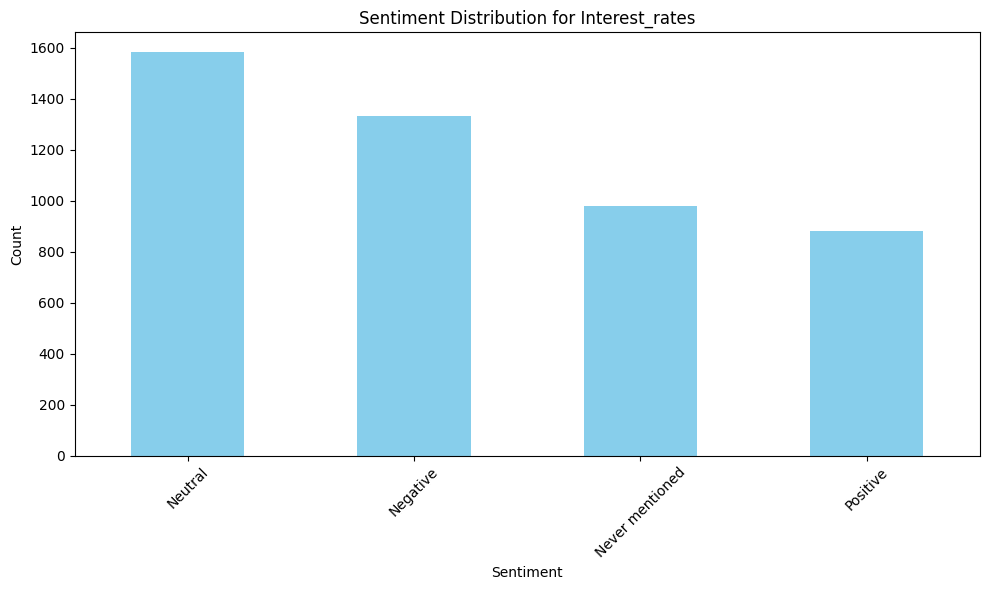

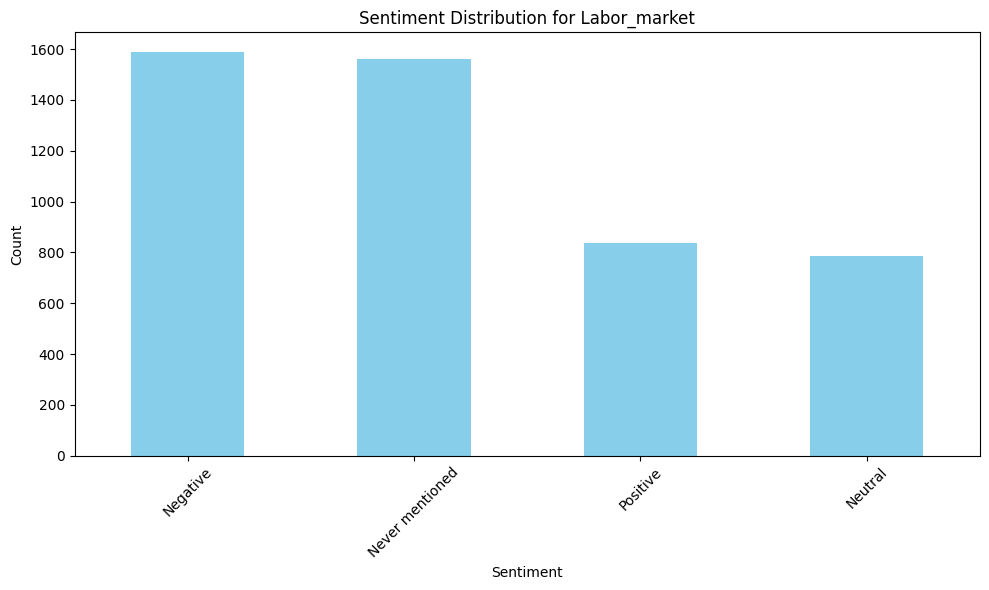

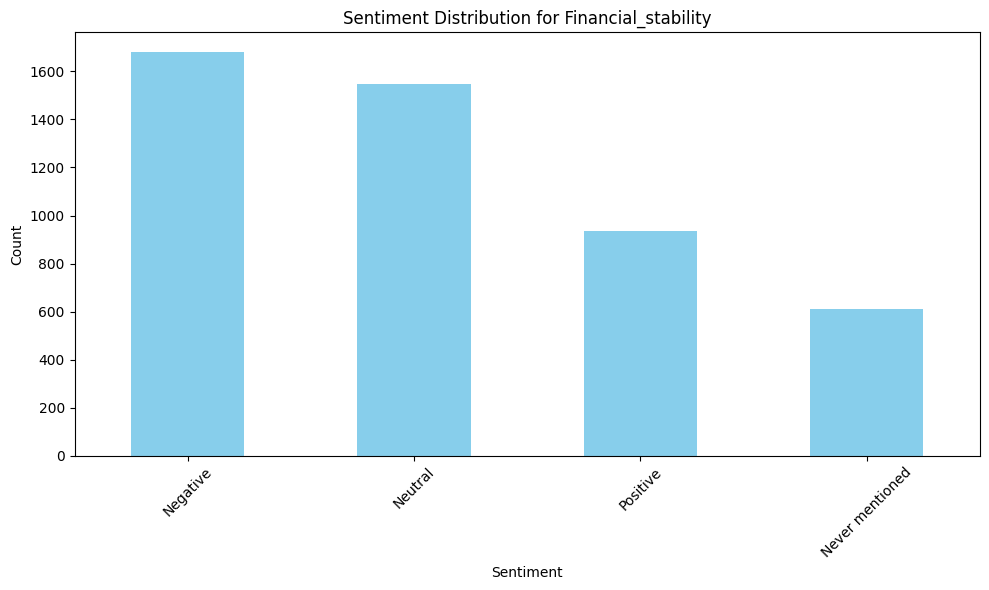

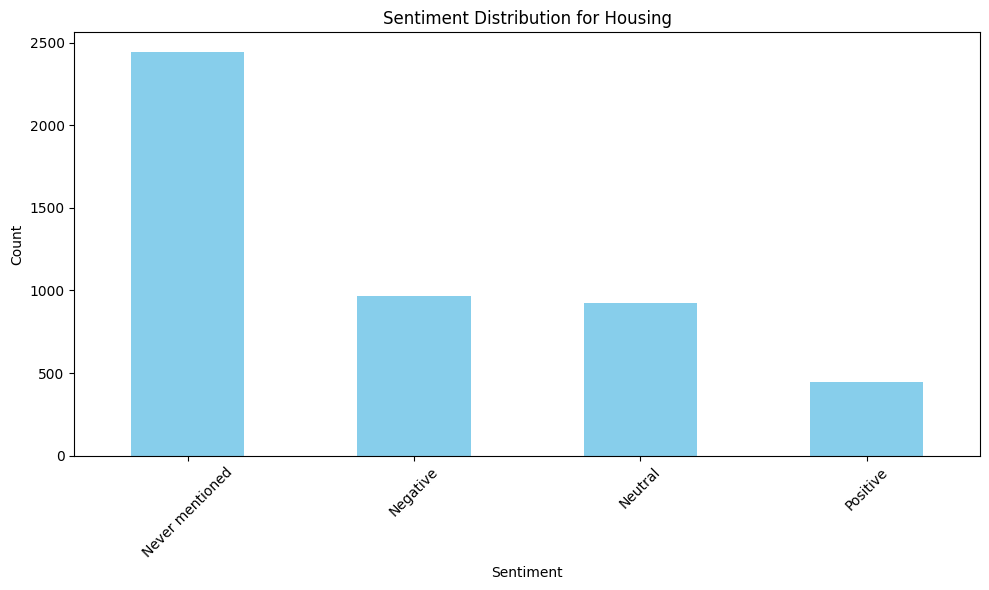

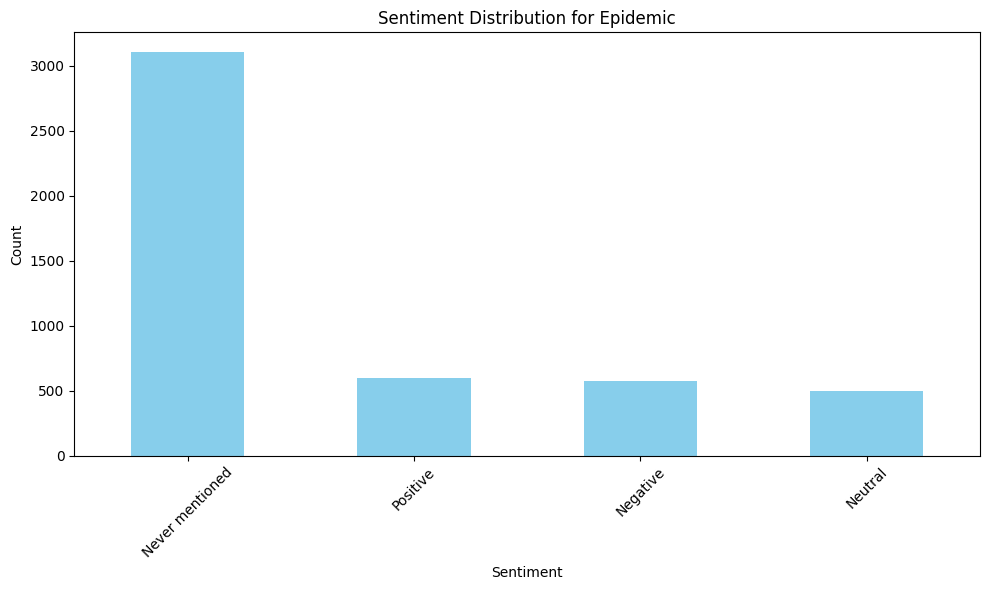

In [8]:
# Plot the sentiment distribution for each aspect
for aspect in aspects.keys():
    plt.figure(figsize=(10, 6))
    column_name = f"sentiment_{aspect.rstrip('s')}"  
    df_sentiment[column_name].value_counts().plot(kind='bar', color='skyblue')
    plt.title(f'Sentiment Distribution for {aspect.capitalize()}')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [9]:
clean_df = df_sentiment

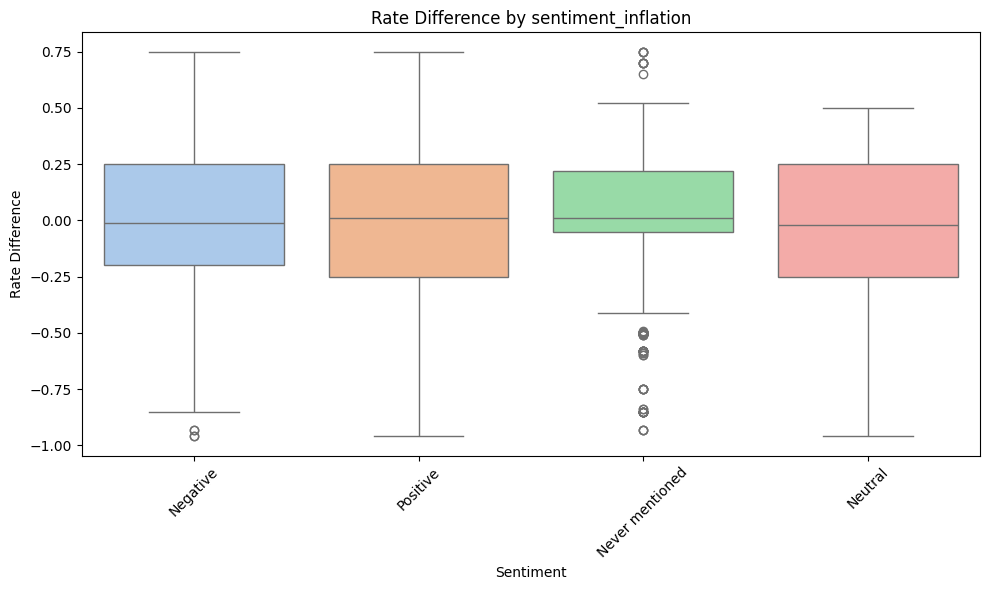

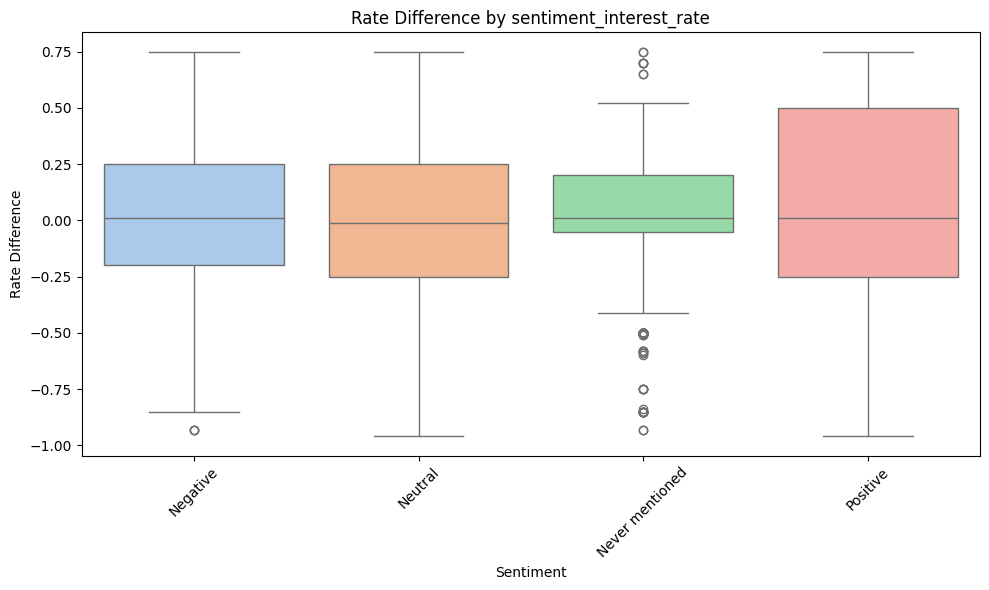

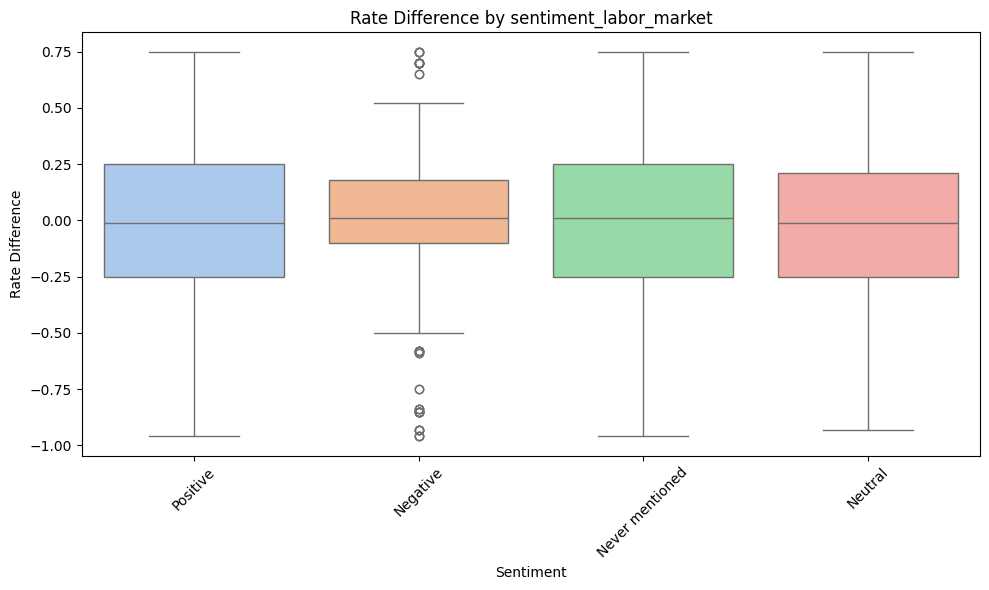

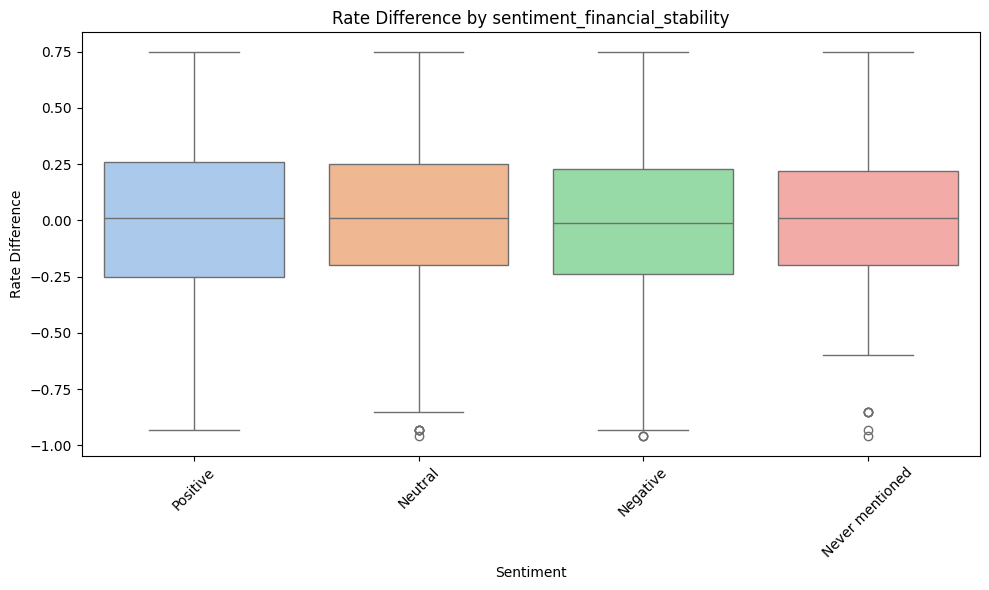

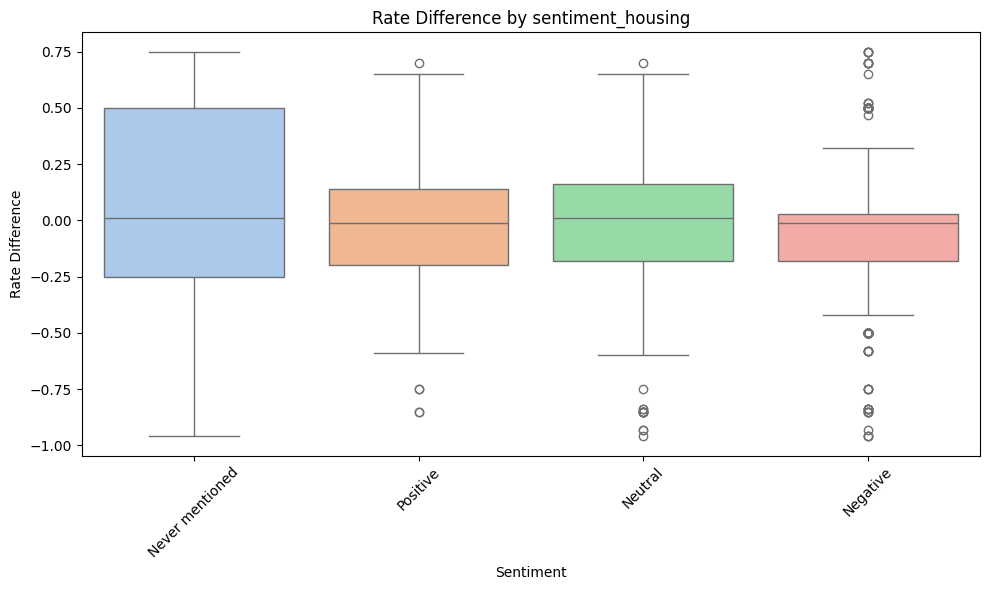

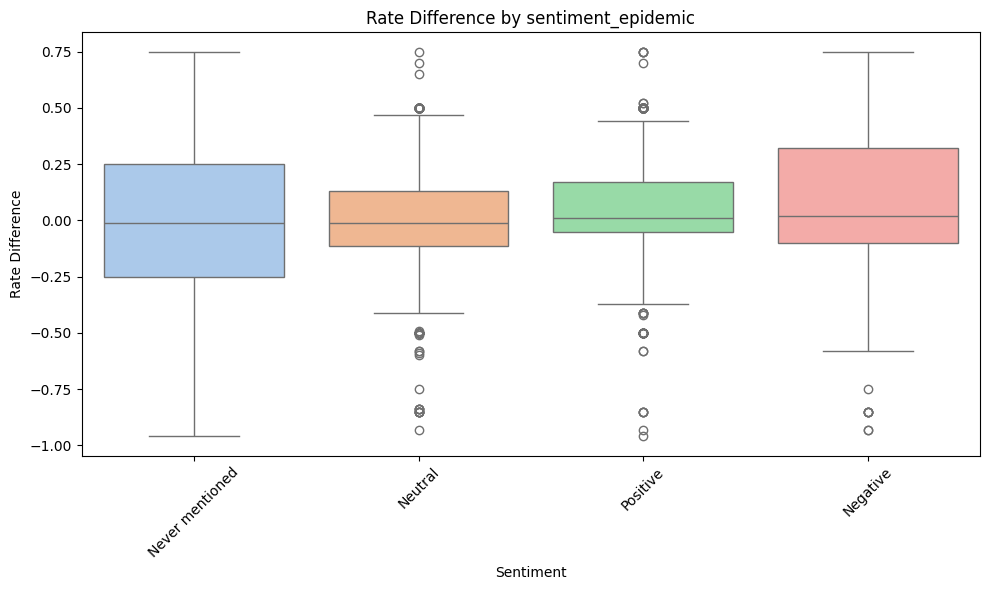

In [10]:
# Boxplots for rate differences by sentiment
sentiment_columns = [col for col in clean_df.columns if col.startswith('sentiment_')]

for col in sentiment_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=clean_df, x=col, y='rate_difference', hue=col, palette='pastel', legend=False)
    plt.title(f'Rate Difference by {col}')
    plt.xlabel('Sentiment')
    plt.ylabel('Rate Difference')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [11]:
# Filtering the DataFrame for ECB and Fed
ecb_df = clean_df[clean_df['country'] == 'Euro area']
fed_df = clean_df[clean_df['country'] == 'United States']

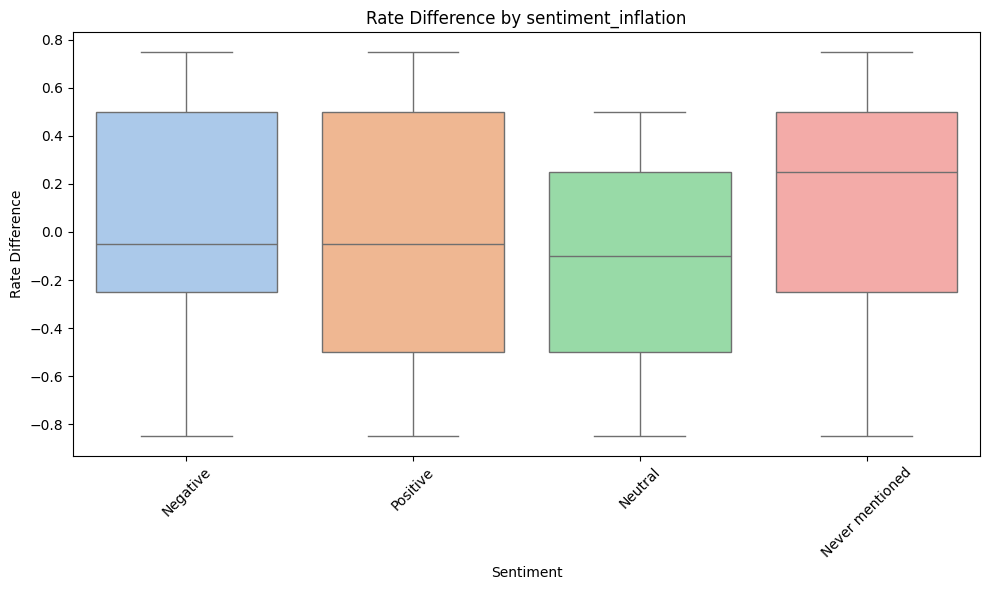

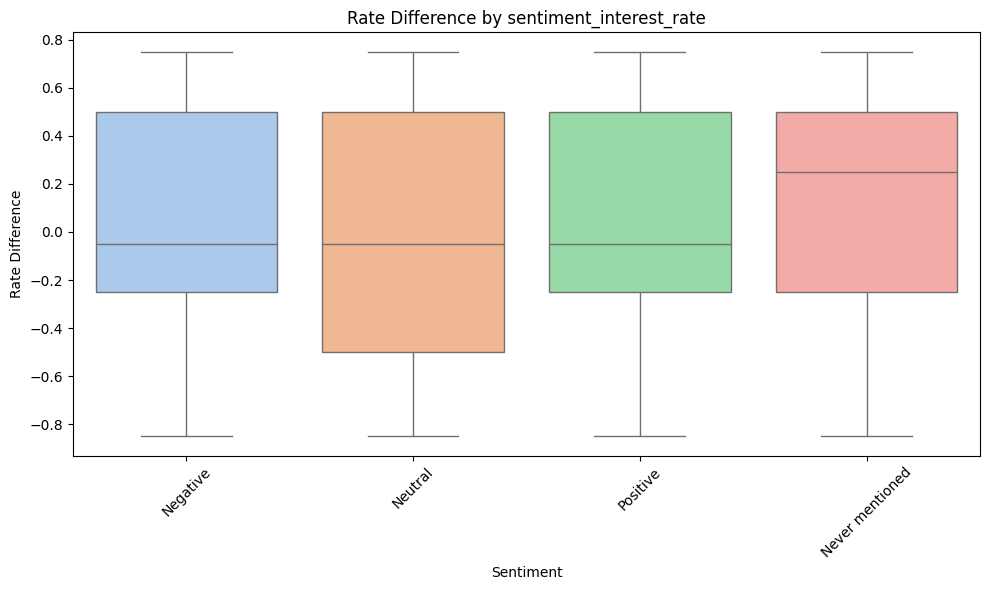

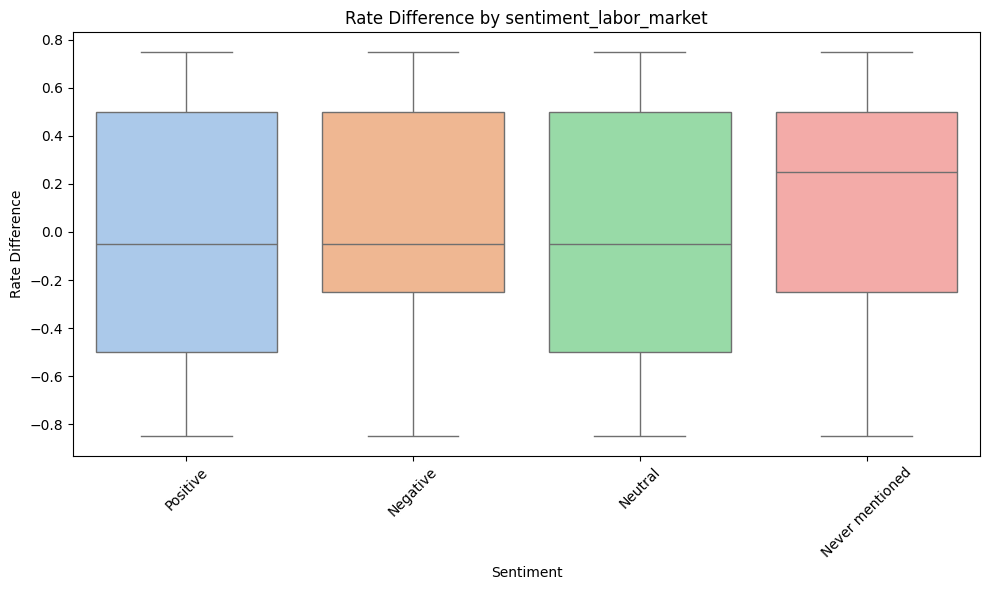

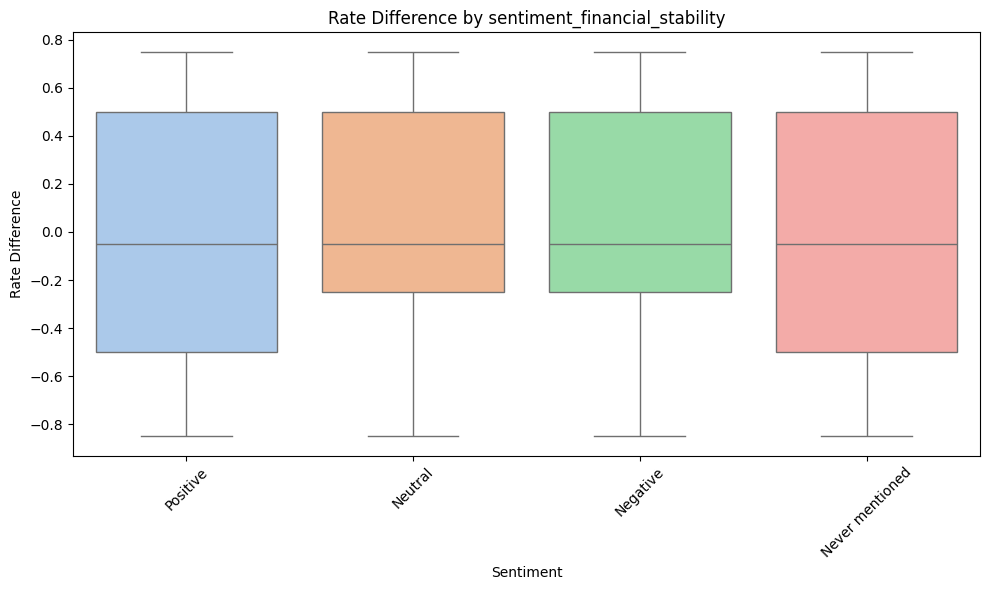

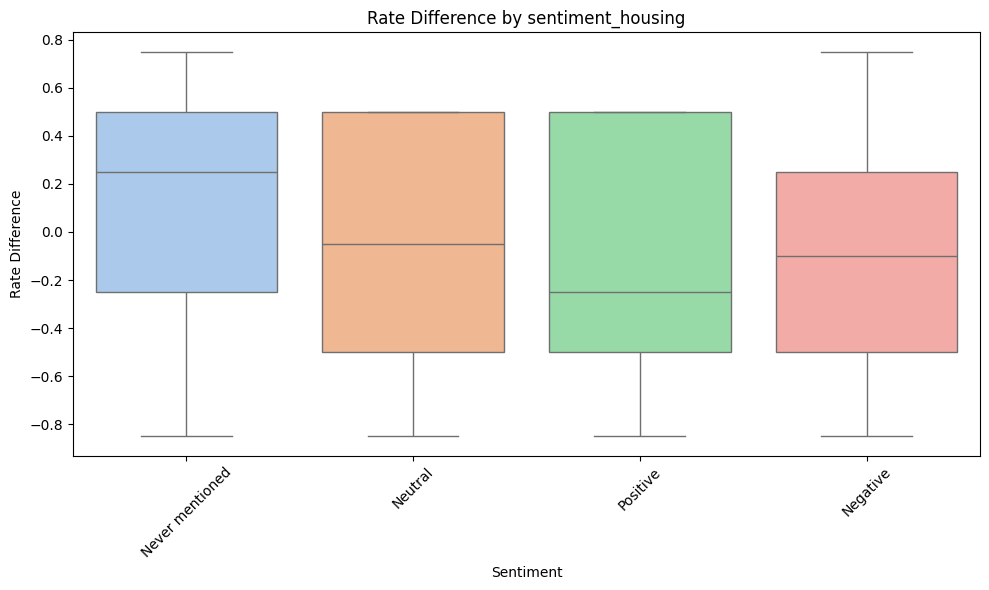

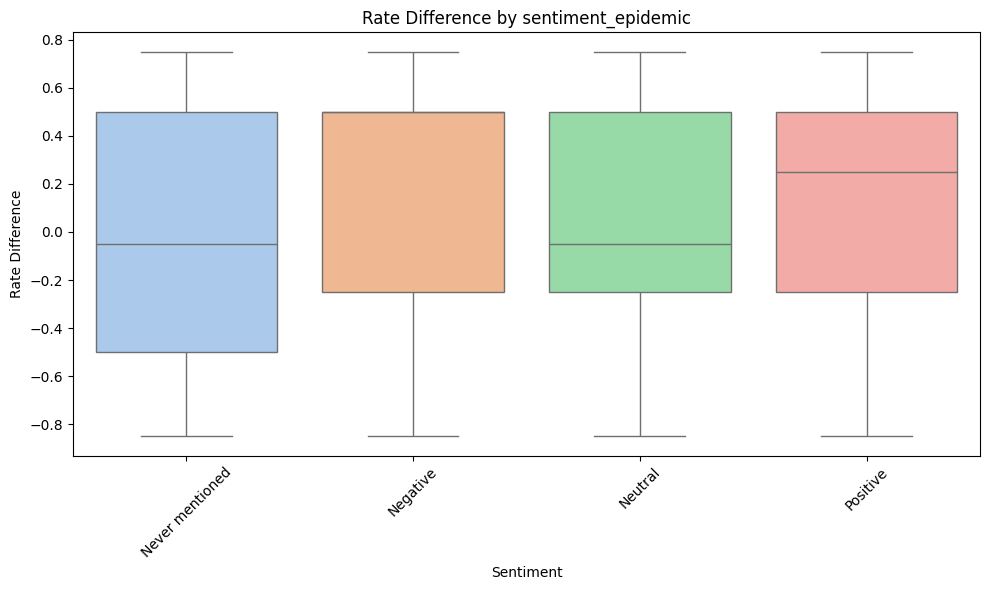

In [12]:
# Boxplots for rate differences by sentiment
sentiment_columns = [col for col in ecb_df.columns if col.startswith('sentiment_')]

for col in sentiment_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=ecb_df, x=col, y='rate_difference', hue=col, palette='pastel', legend=False)
    plt.title(f'Rate Difference by {col}')
    plt.xlabel('Sentiment')
    plt.ylabel('Rate Difference')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


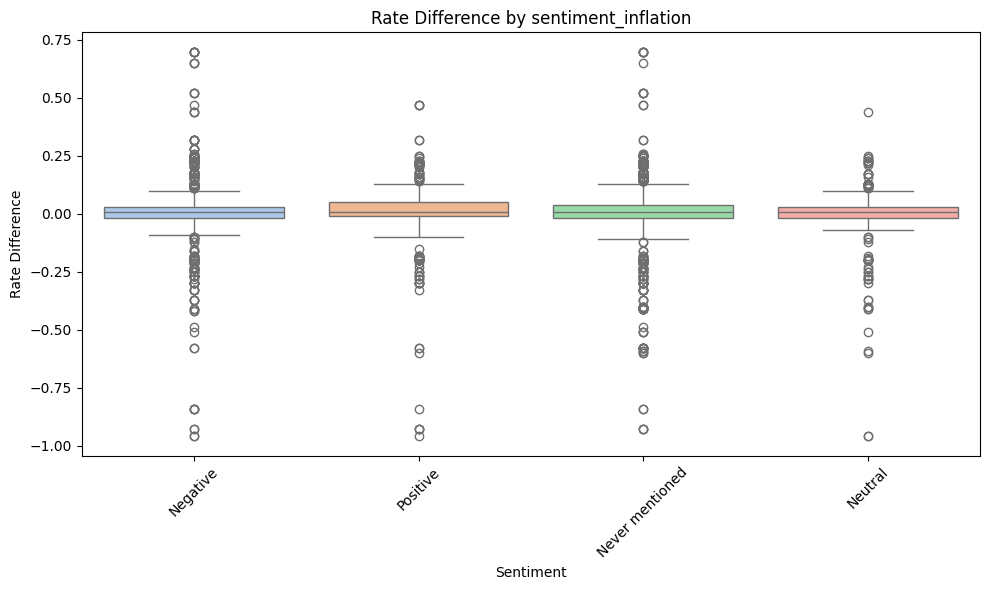

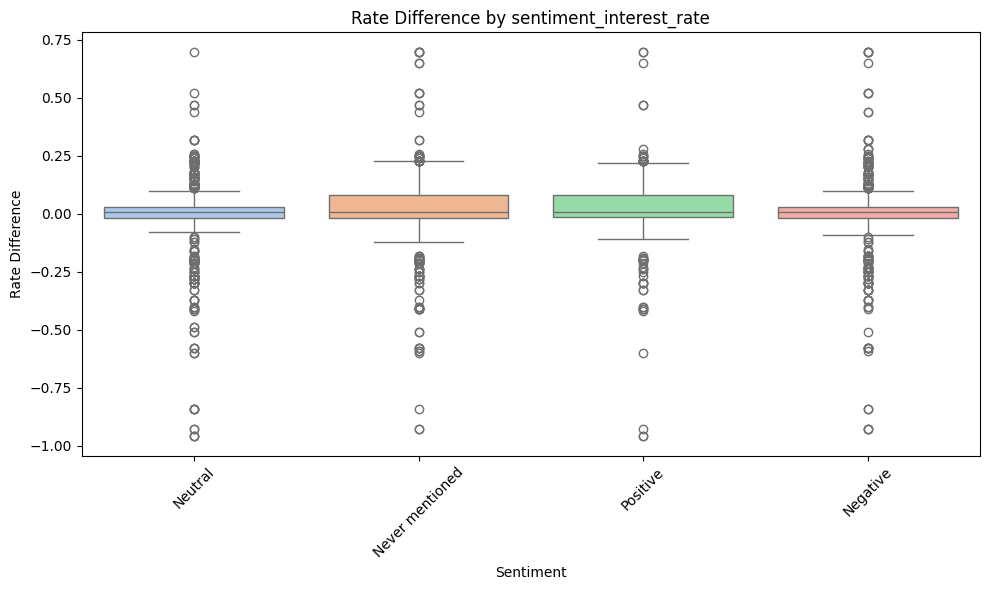

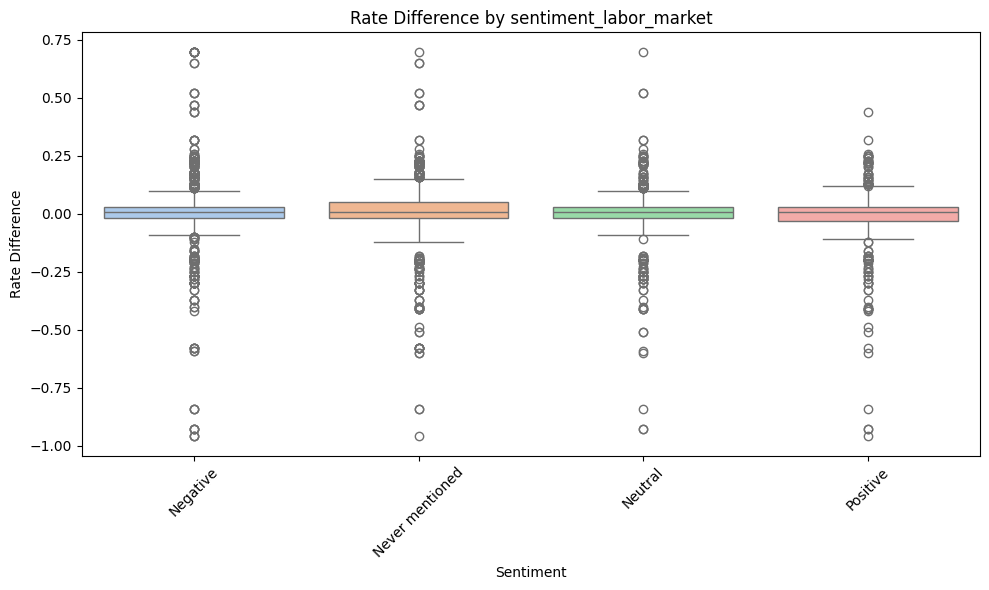

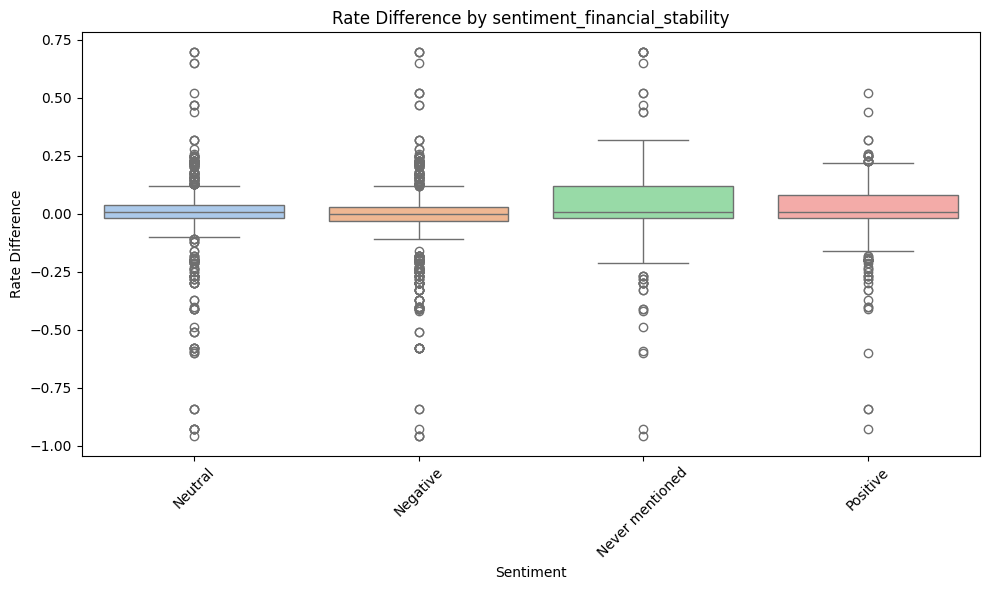

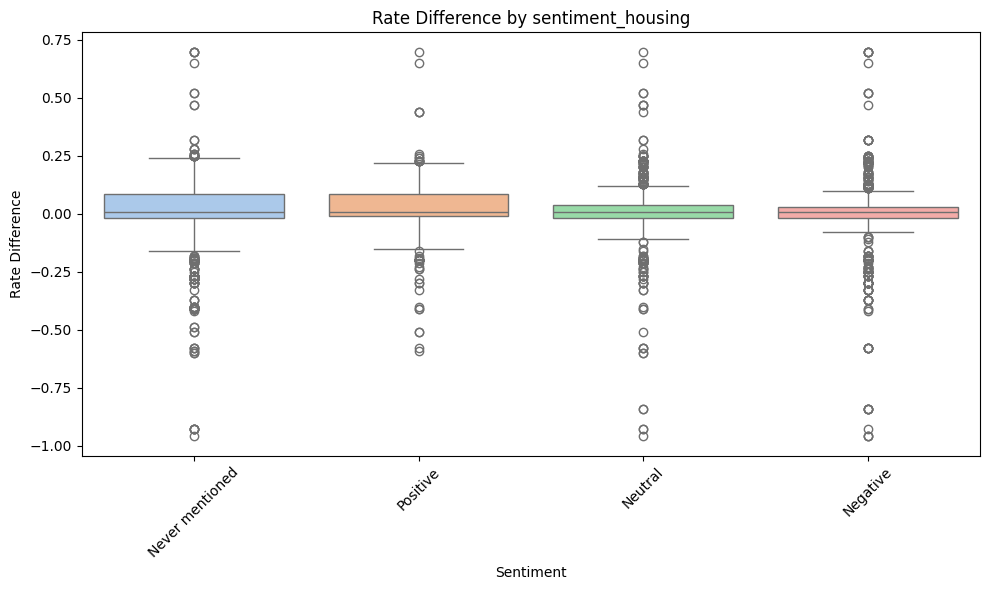

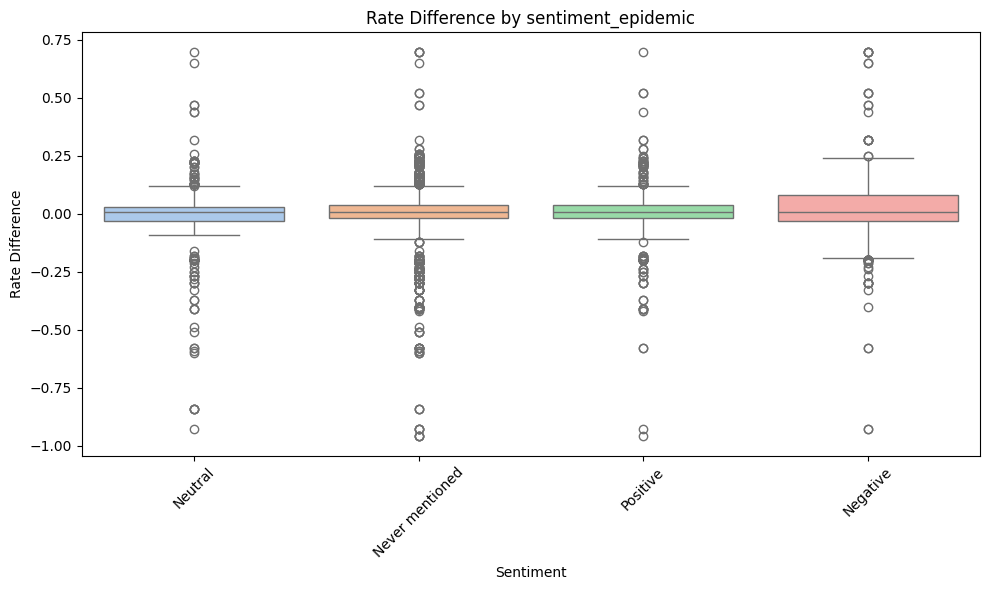

In [13]:
# Boxplots for rate differences by sentiment
sentiment_columns = [col for col in fed_df.columns if col.startswith('sentiment_')]

for col in sentiment_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=fed_df, x=col, y='rate_difference', hue=col, palette='pastel', legend=False)
    plt.title(f'Rate Difference by {col}')
    plt.xlabel('Sentiment')
    plt.ylabel('Rate Difference')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Creating Timelines

Here, I am creating timelines for short-term (7-days), medium-term (15-days) and long-term (30-days).

## 7 days


In [14]:
def aggregate_pre_decision_speeches_sevend(df):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['next_rate_date'] = pd.to_datetime(df['next_rate_date'])
    aggregated_rows = []
    decision_dates = df['next_rate_date'].dropna().unique()
    sentiment_cols = [col for col in df.columns if col.startswith('sentiment_')]

    for decision_date in decision_dates:
        # Filter speeches from the week before the decision date
        mask = (df['date'] >= decision_date - pd.Timedelta(days=7)) & (df['date'] < decision_date)
        speeches = df[mask]

        if speeches.empty:
            continue  

        # For sentiment columns, calculate the mode
        sentiment_modes = {
            col: speeches[col].mode(dropna=True)[0] if not speeches[col].mode(dropna=True).empty else None
            for col in sentiment_cols
        }

        aggregated_rows.append({
            'next_rate_date': decision_date,
            'num_speeches': len(speeches),
            'rate_difference': speeches['rate_difference'].mean(),
            **sentiment_modes
        })
    return pd.DataFrame(aggregated_rows)


In [15]:
# Using the function above to aggregate speeches for ECB and Fed
ecb_agg_seven = aggregate_pre_decision_speeches_sevend(ecb_df)
fed_agg_seven = aggregate_pre_decision_speeches_sevend(fed_df)

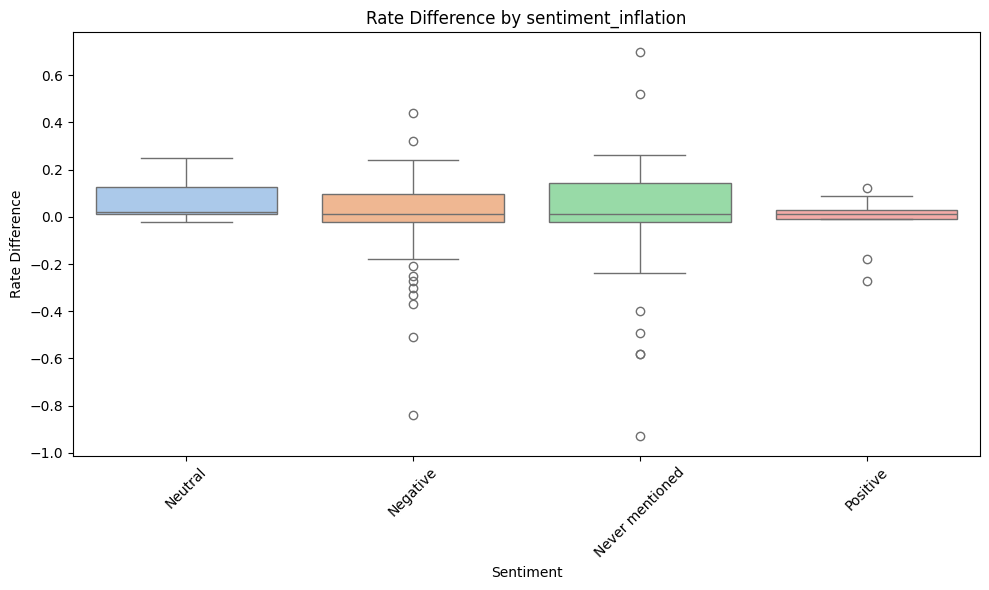

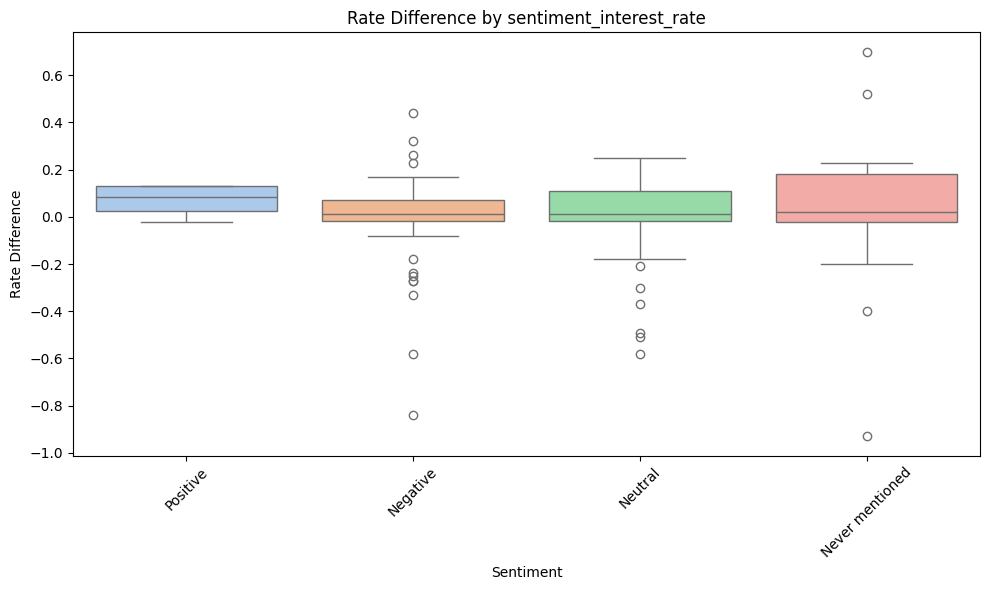

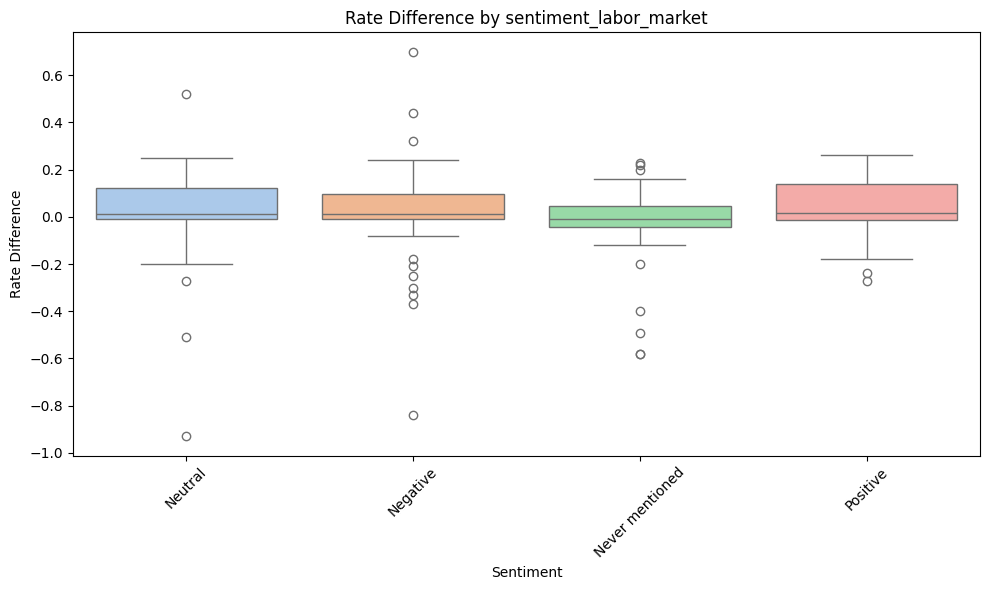

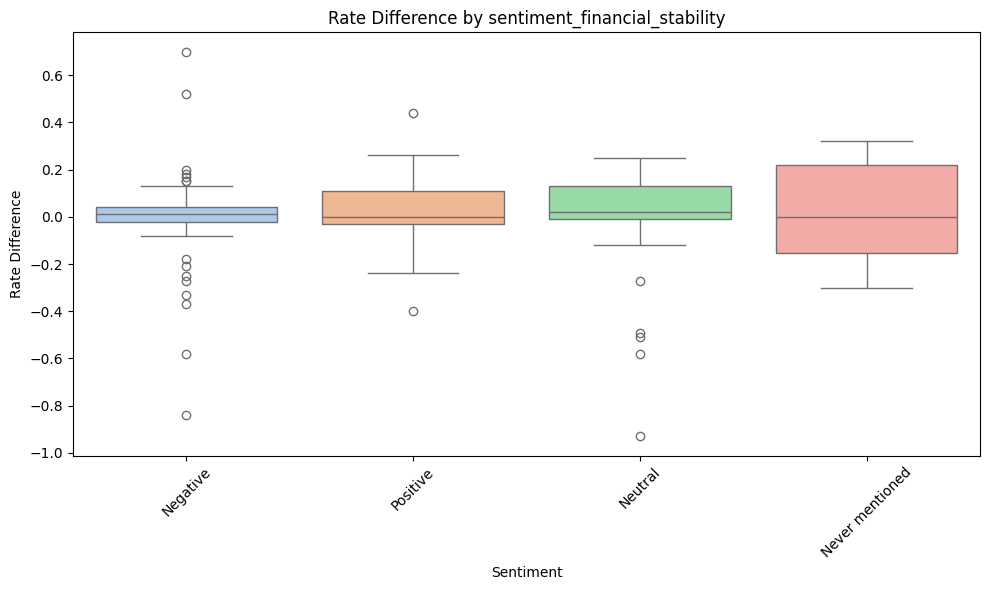

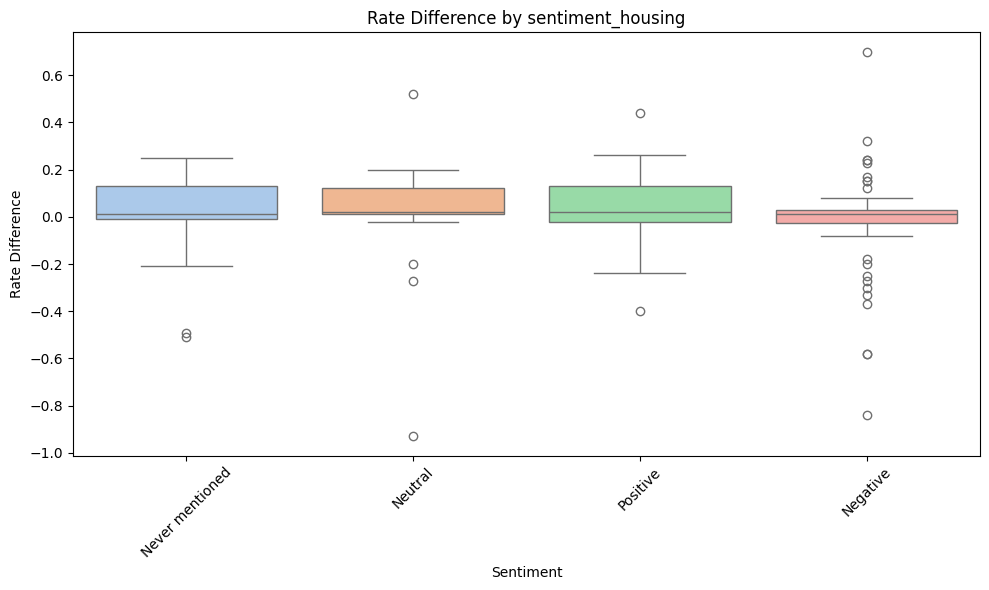

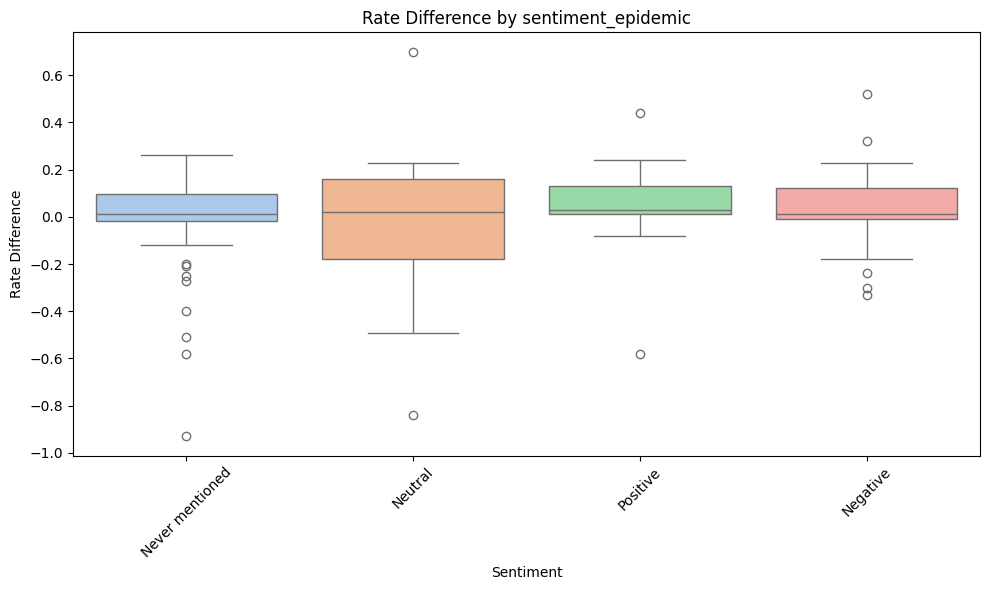

In [16]:
# plot the rate difference by sentiment for FED
sentiment_columns = [col for col in fed_agg_seven.columns if col.startswith('sentiment_')]

for col in sentiment_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=fed_agg_seven, x=col, y='rate_difference', hue=col, palette='pastel', legend=False)
    plt.title(f'Rate Difference by {col}')
    plt.xlabel('Sentiment')
    plt.ylabel('Rate Difference')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


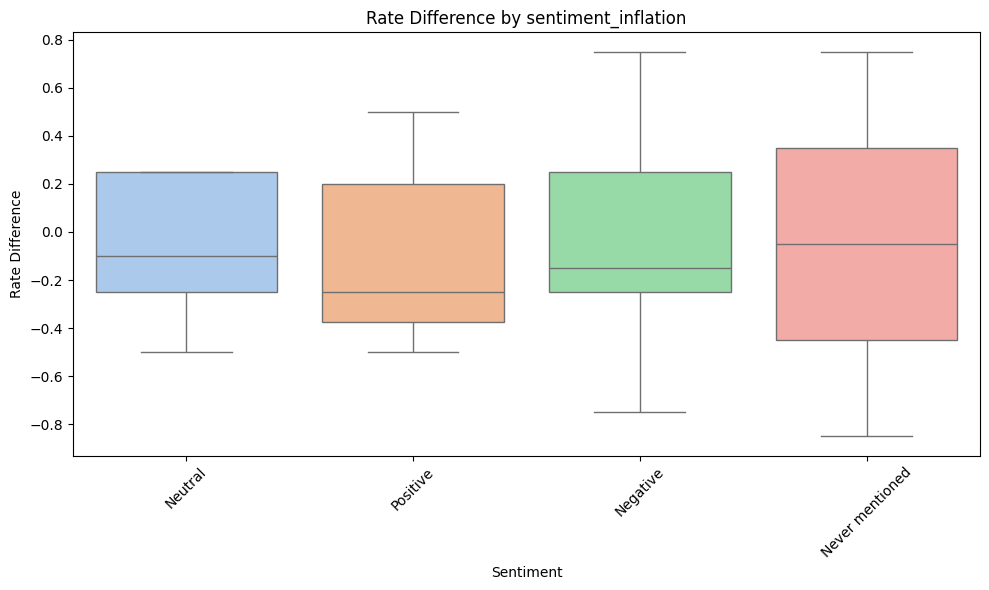

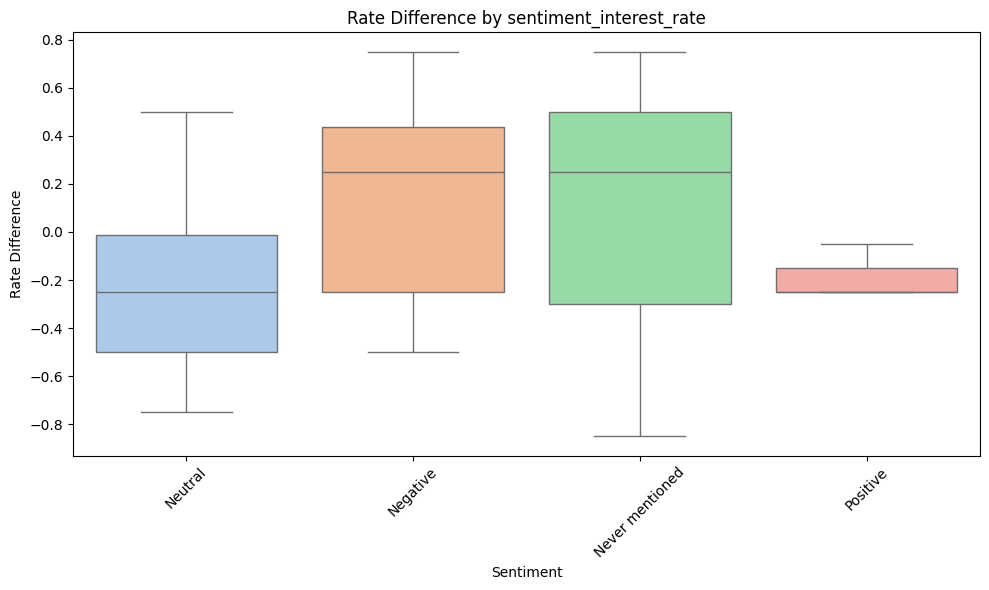

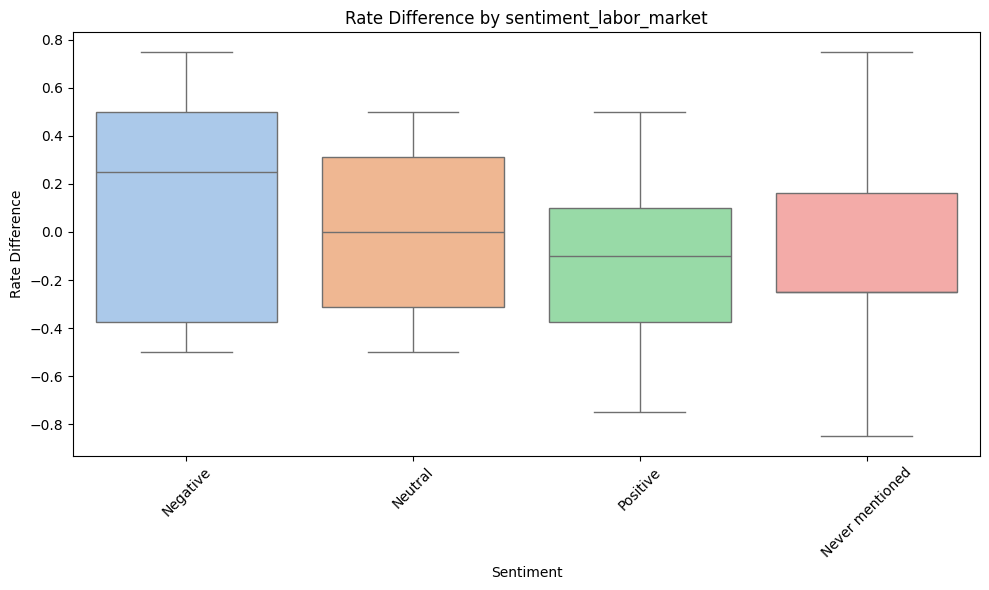

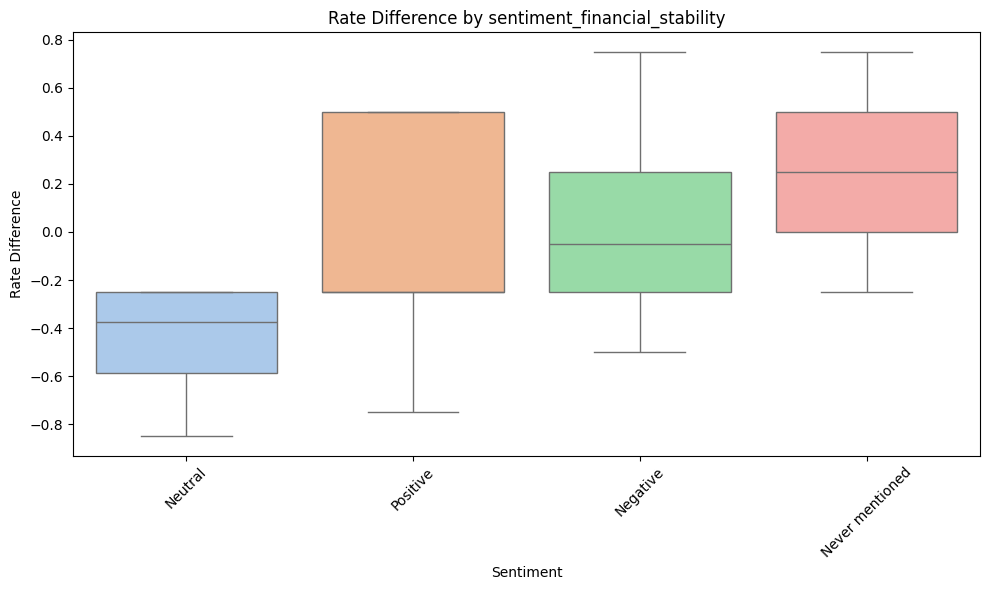

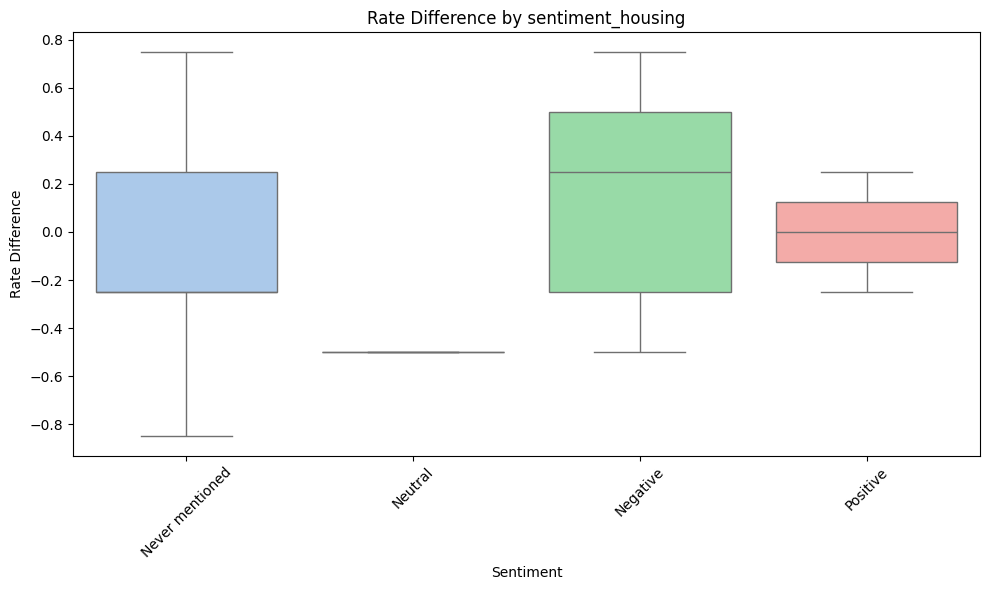

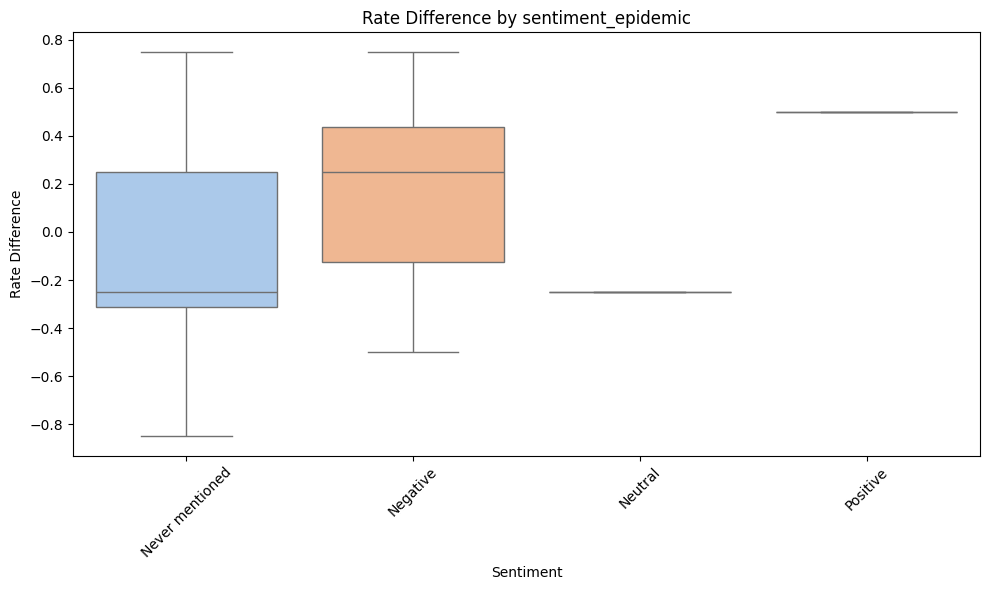

In [17]:
# plot the rate difference by sentiment for ECB

sentiment_columns = [col for col in ecb_agg_seven.columns if col.startswith('sentiment_')]

for col in sentiment_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=ecb_agg_seven, x=col, y='rate_difference', hue=col, palette='pastel', legend=False)
    plt.title(f'Rate Difference by {col}')
    plt.xlabel('Sentiment')
    plt.ylabel('Rate Difference')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [18]:
# Print the sentiment distribution for each aspect
print("ECB Aggregated (7 Days):")
for col in sentiment_columns:
    print(f"\n{col}:")
    print(ecb_agg_seven[col].value_counts())

print("\nFED Aggregated (7 Days):")
for col in sentiment_columns:
    print(f"\n{col}:")
    print(fed_agg_seven[col].value_counts())

ECB Aggregated (7 Days):

sentiment_inflation:
sentiment_inflation
Negative           18
Positive            7
Neutral             5
Never mentioned     2
Name: count, dtype: int64

sentiment_interest_rate:
sentiment_interest_rate
Negative           14
Neutral            12
Never mentioned     3
Positive            3
Name: count, dtype: int64

sentiment_labor_market:
sentiment_labor_market
Negative           11
Never mentioned    10
Positive            7
Neutral             4
Name: count, dtype: int64

sentiment_financial_stability:
sentiment_financial_stability
Negative           21
Positive            5
Neutral             4
Never mentioned     2
Name: count, dtype: int64

sentiment_housing:
sentiment_housing
Never mentioned    20
Negative            9
Positive            2
Neutral             1
Name: count, dtype: int64

sentiment_epidemic:
sentiment_epidemic
Never mentioned    24
Negative            6
Neutral             1
Positive            1
Name: count, dtype: int64

FED Aggreg

## 15 Days

In [19]:
def aggregate_pre_decision_speeches_fifteend(df):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['next_rate_date'] = pd.to_datetime(df['next_rate_date'])
    aggregated_rows = []
    decision_dates = df['next_rate_date'].dropna().unique()
    sentiment_cols = [col for col in df.columns if col.startswith('sentiment_')]

    for decision_date in decision_dates:
        # Filter speeches from the 15 days before the decision date
        mask = (df['date'] >= decision_date - pd.Timedelta(days=15)) & (df['date'] < decision_date)
        speeches = df[mask]

        if speeches.empty:
            continue  

        # For each sentiment column, calculate the mode
        sentiment_modes = {
            col: speeches[col].mode(dropna=True)[0] if not speeches[col].mode(dropna=True).empty else None
            for col in sentiment_cols
        }

        aggregated_rows.append({
            'next_rate_date': decision_date,
            'num_speeches': len(speeches),
            'rate_difference': speeches['rate_difference'].mean(),
            **sentiment_modes
        })
    return pd.DataFrame(aggregated_rows)


In [20]:
# Using the function to aggregate speeches for ECB and Fed
ecb_agg_fifteen = aggregate_pre_decision_speeches_fifteend(ecb_df)
fed_agg_fifteen = aggregate_pre_decision_speeches_fifteend(fed_df)

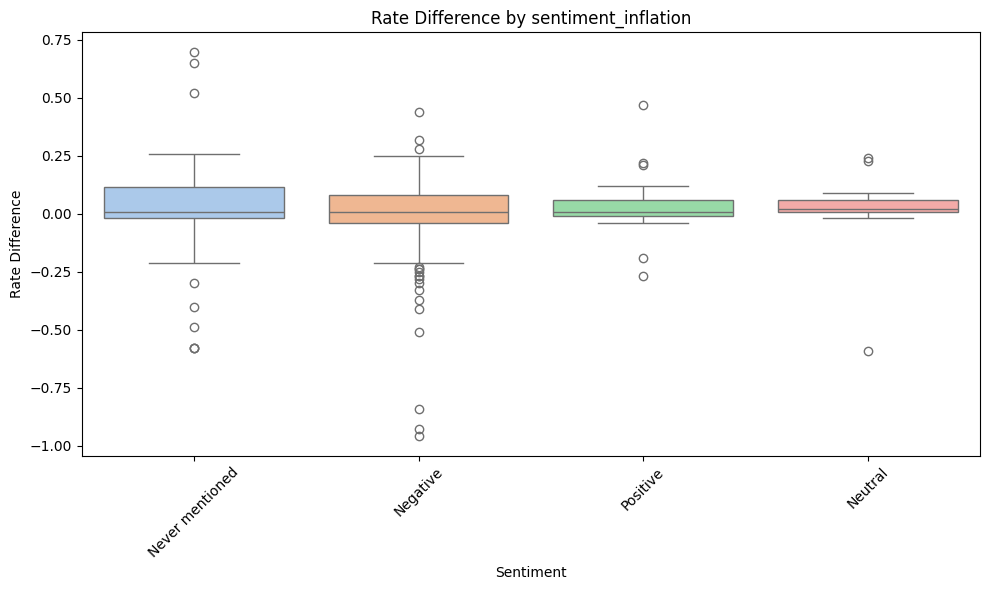

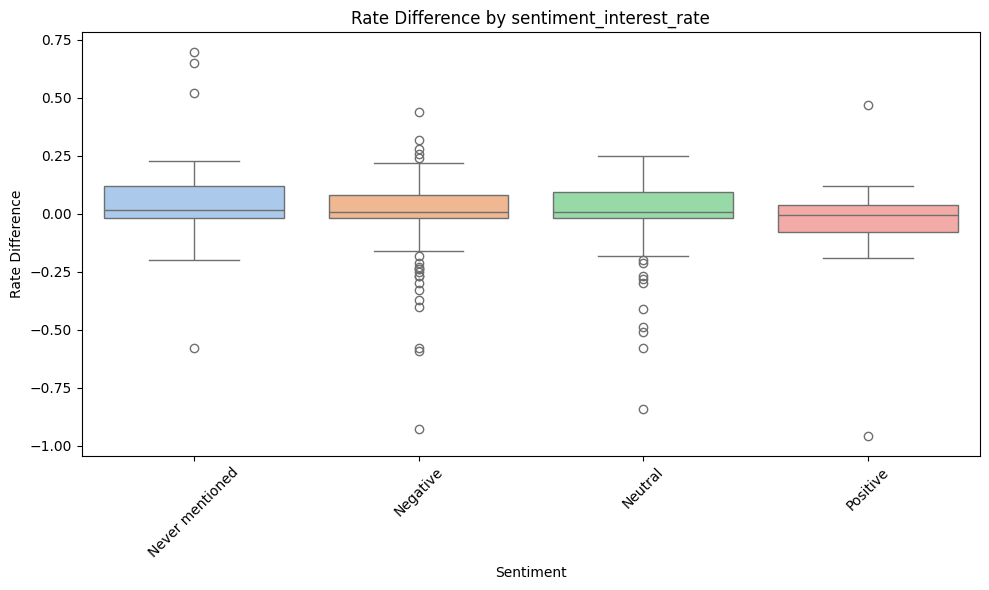

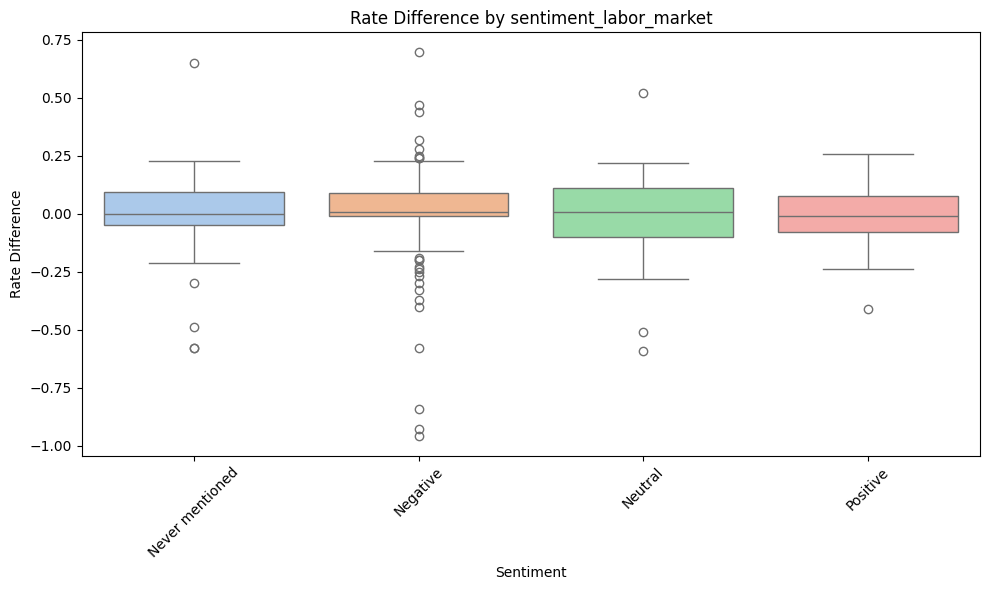

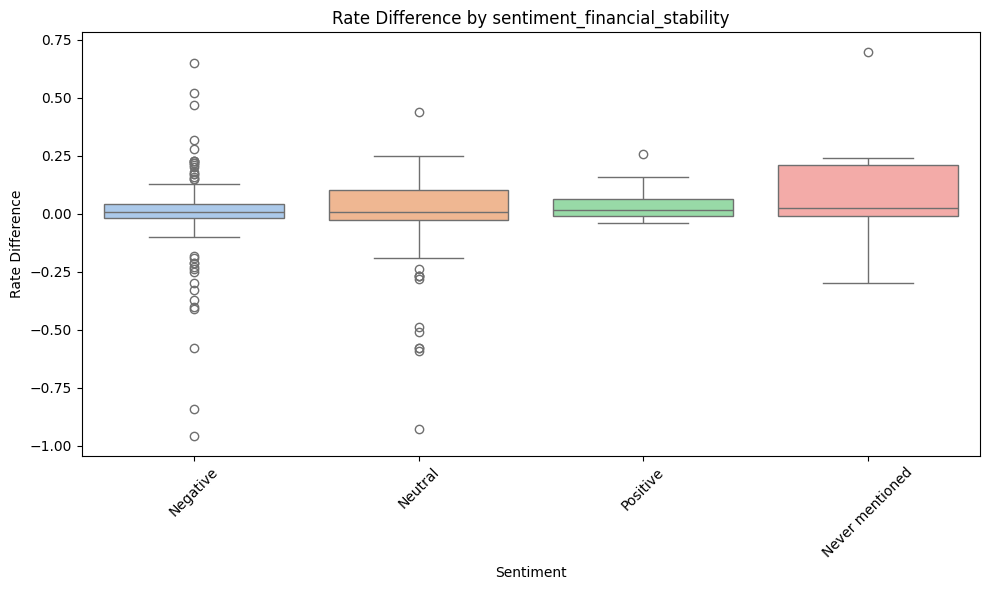

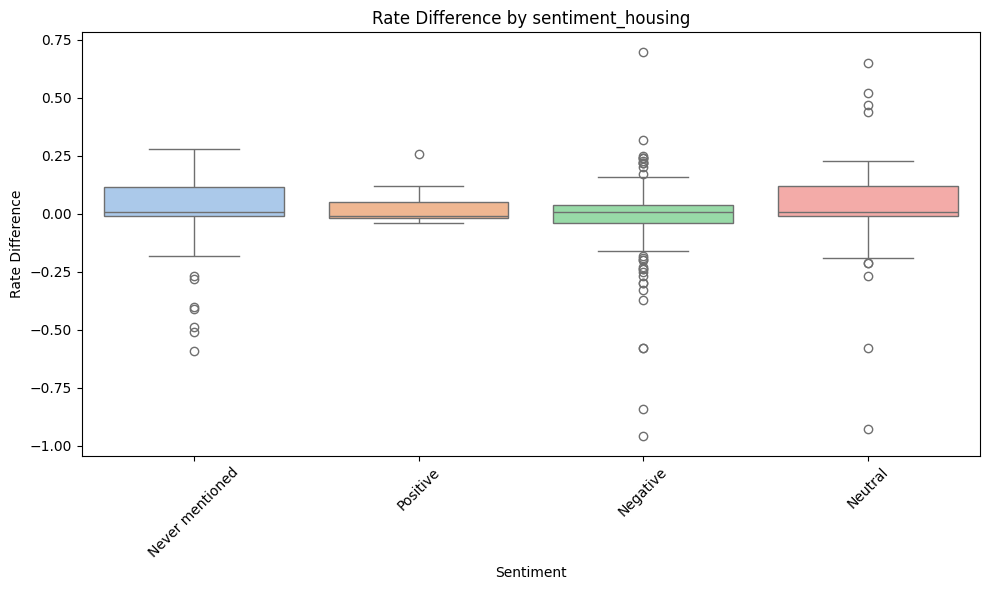

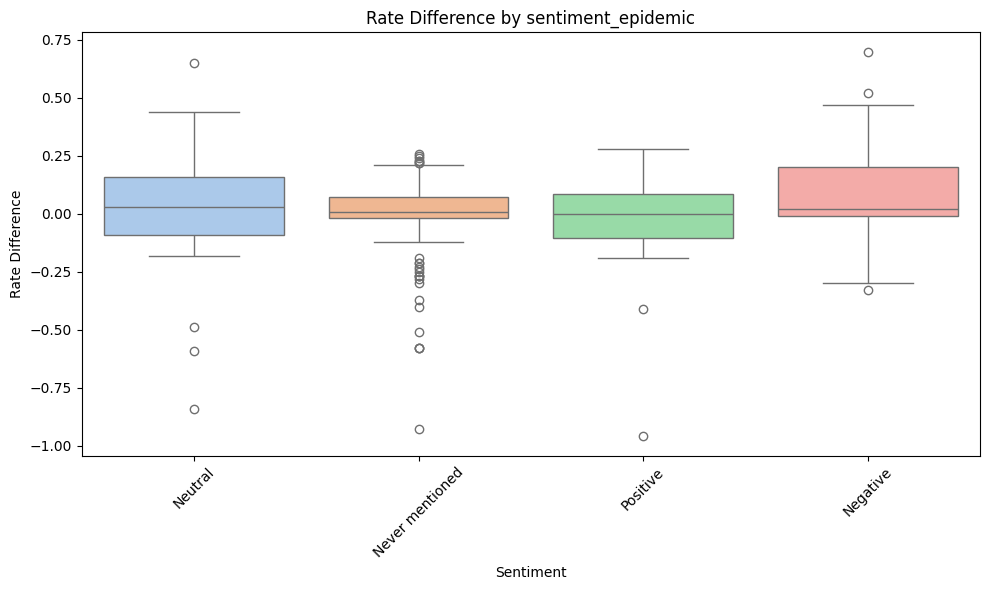

In [21]:
# Plot the rate difference by sentiment for FED
sentiment_columns = [col for col in fed_agg_fifteen.columns if col.startswith('sentiment_')]

for col in sentiment_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=fed_agg_fifteen, x=col, y='rate_difference', hue=col, palette='pastel', legend=False)
    plt.title(f'Rate Difference by {col}')
    plt.xlabel('Sentiment')
    plt.ylabel('Rate Difference')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


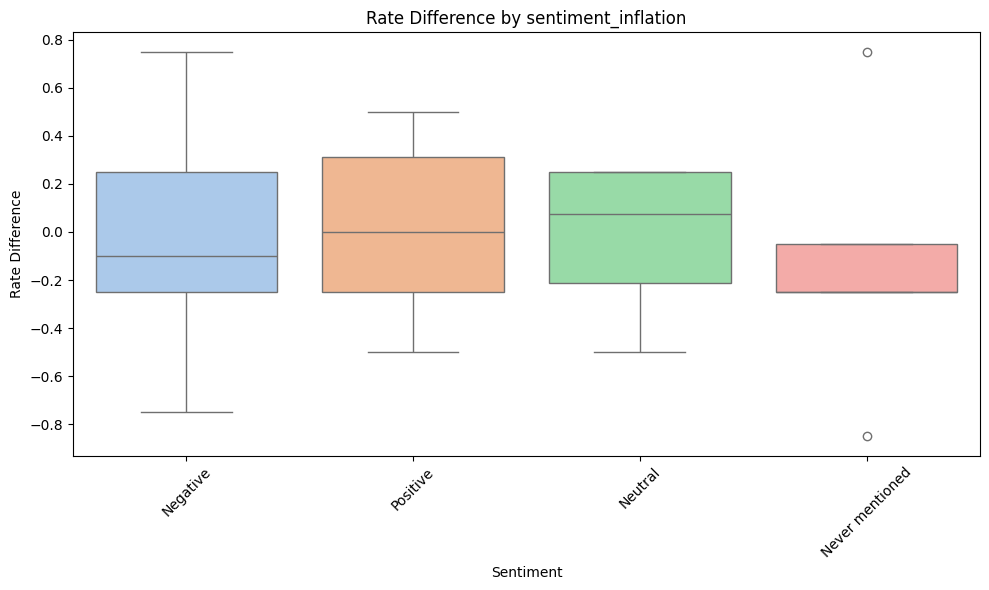

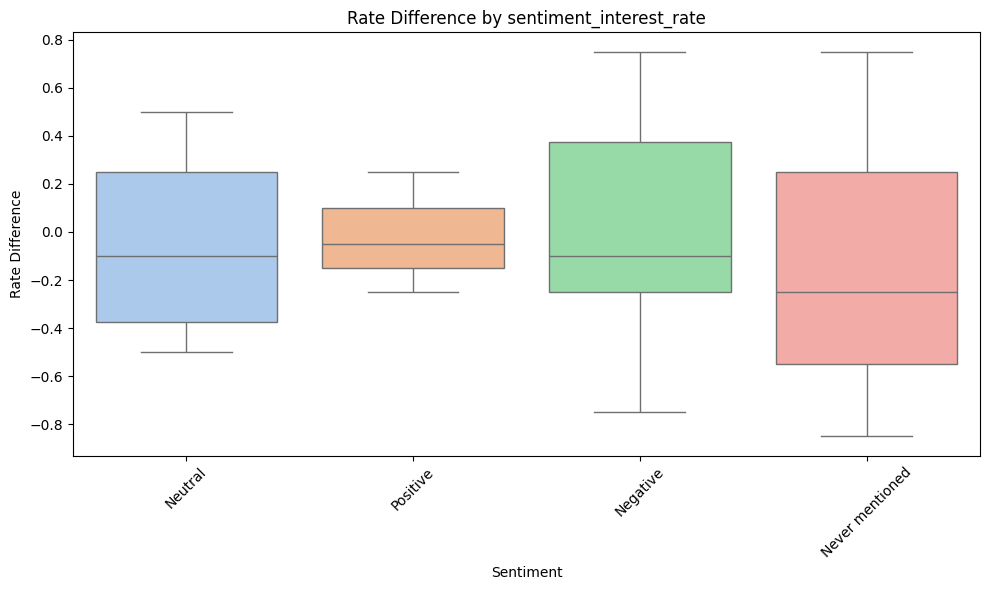

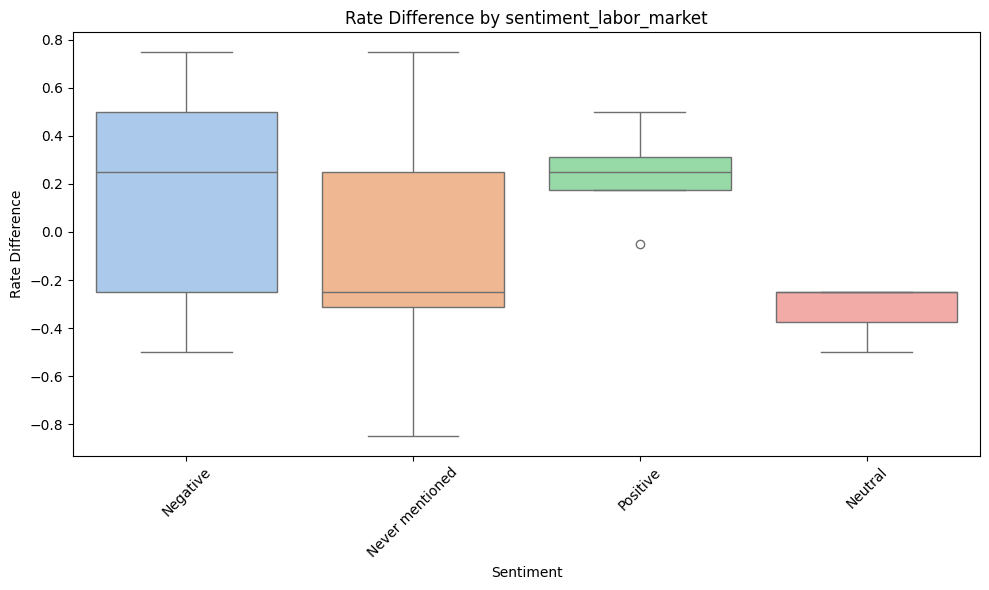

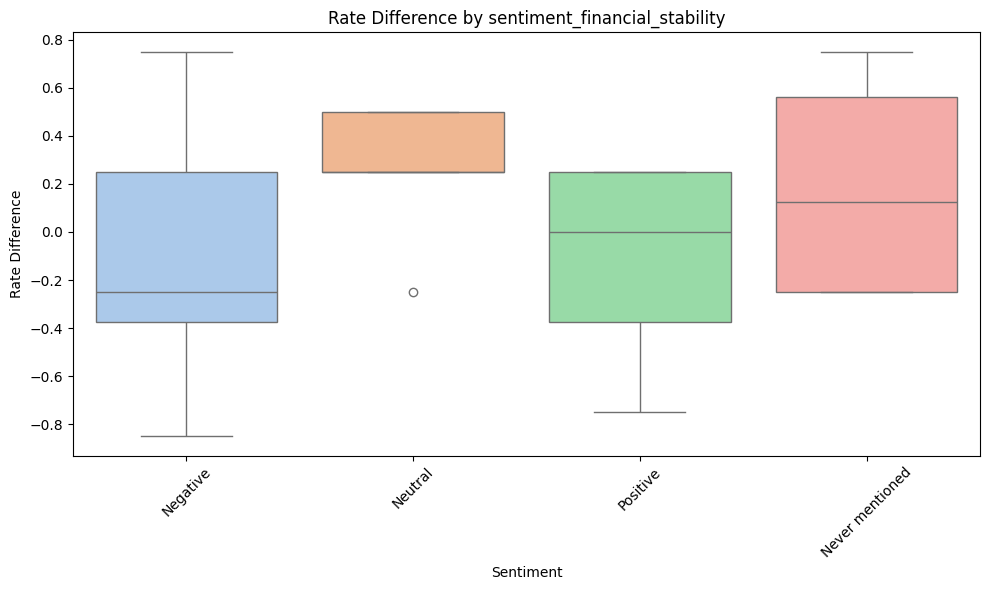

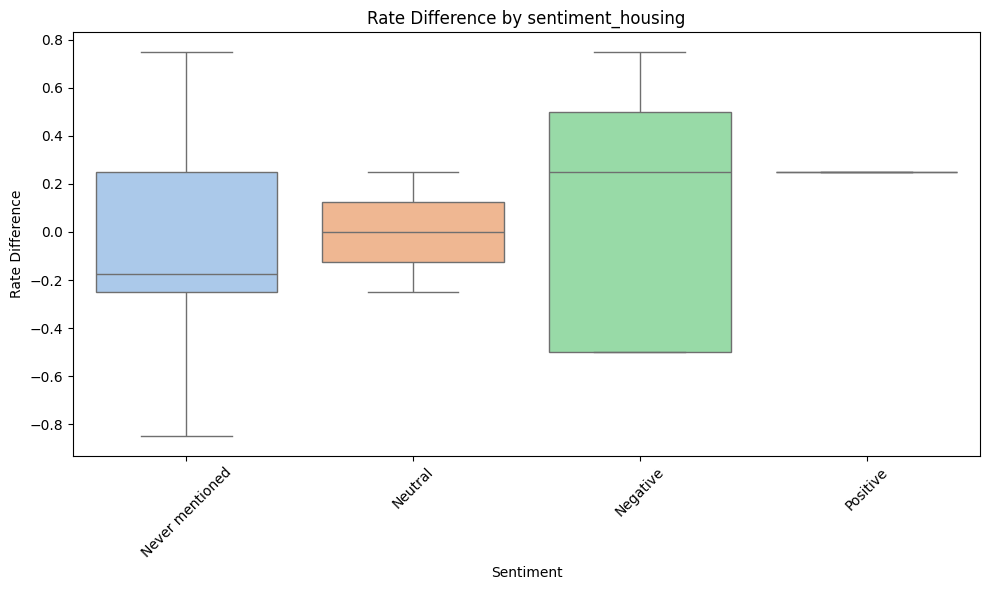

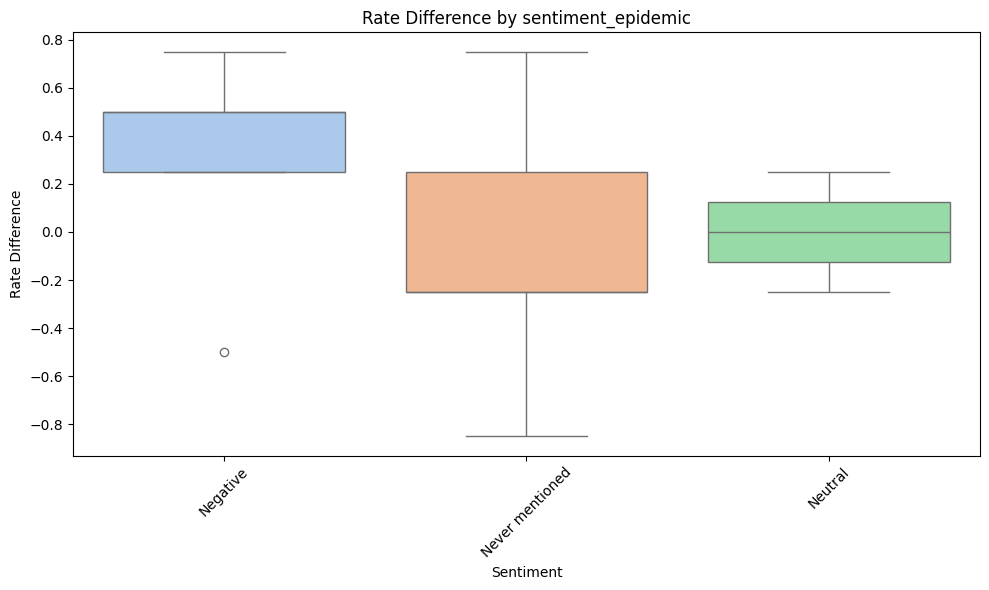

In [22]:
# Plot the rate difference by sentiment for ECB
sentiment_columns = [col for col in ecb_agg_fifteen.columns if col.startswith('sentiment_')]

for col in sentiment_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=ecb_agg_fifteen, x=col, y='rate_difference', hue=col, palette='pastel', legend=False)
    plt.title(f'Rate Difference by {col}')
    plt.xlabel('Sentiment')
    plt.ylabel('Rate Difference')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [23]:
# Print the sentiment distribution for each aspect
print("ECB Aggregated (15 Days):")
for col in sentiment_columns:
    print(f"\n{col}:")
    print(ecb_agg_fifteen[col].value_counts())

print("\nFED Aggregated (15 Days):")
for col in sentiment_columns:
    print(f"\n{col}:")
    print(fed_agg_fifteen[col].value_counts())

ECB Aggregated (15 Days):

sentiment_inflation:
sentiment_inflation
Negative           17
Positive            8
Neutral             6
Never mentioned     5
Name: count, dtype: int64

sentiment_interest_rate:
sentiment_interest_rate
Neutral            15
Negative           15
Positive            3
Never mentioned     3
Name: count, dtype: int64

sentiment_labor_market:
sentiment_labor_market
Never mentioned    16
Negative           13
Positive            4
Neutral             3
Name: count, dtype: int64

sentiment_financial_stability:
sentiment_financial_stability
Negative           23
Neutral             5
Positive            4
Never mentioned     4
Name: count, dtype: int64

sentiment_housing:
sentiment_housing
Never mentioned    28
Negative            5
Neutral             2
Positive            1
Name: count, dtype: int64

sentiment_epidemic:
sentiment_epidemic
Never mentioned    29
Negative            5
Neutral             2
Name: count, dtype: int64

FED Aggregated (15 Days):

sent

## 30 days

In [24]:
def aggregate_pre_decision_speeches_thirtyd(df):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['next_rate_date'] = pd.to_datetime(df['next_rate_date'])
    aggregated_rows = []
    decision_dates = df['next_rate_date'].dropna().unique()
    sentiment_cols = [col for col in df.columns if col.startswith('sentiment_')]

    for decision_date in decision_dates:
        # Filter speeches from the 30 days before the decision date
        mask = (df['date'] >= decision_date - pd.Timedelta(days=30)) & (df['date'] < decision_date)
        speeches = df[mask]

        if speeches.empty:
            continue  

        # For each sentiment column, calculate the mode
        sentiment_modes = {
            col: speeches[col].mode(dropna=True)[0] if not speeches[col].mode(dropna=True).empty else None
            for col in sentiment_cols
        }

        aggregated_rows.append({
            'next_rate_date': decision_date,
            'num_speeches': len(speeches),
            'rate_difference': speeches['rate_difference'].mean(),
            **sentiment_modes
        })
    return pd.DataFrame(aggregated_rows)


In [25]:
# Using the function to aggregate speeches for ECB and Fed
ecb_agg_thirty = aggregate_pre_decision_speeches_thirtyd(ecb_df)
fed_agg_thirty = aggregate_pre_decision_speeches_thirtyd(fed_df)

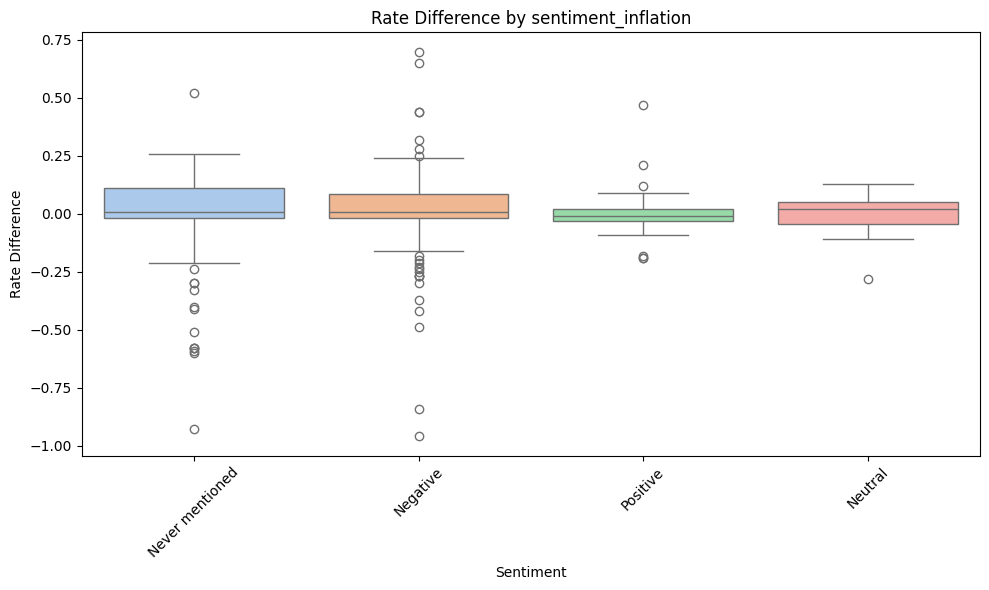

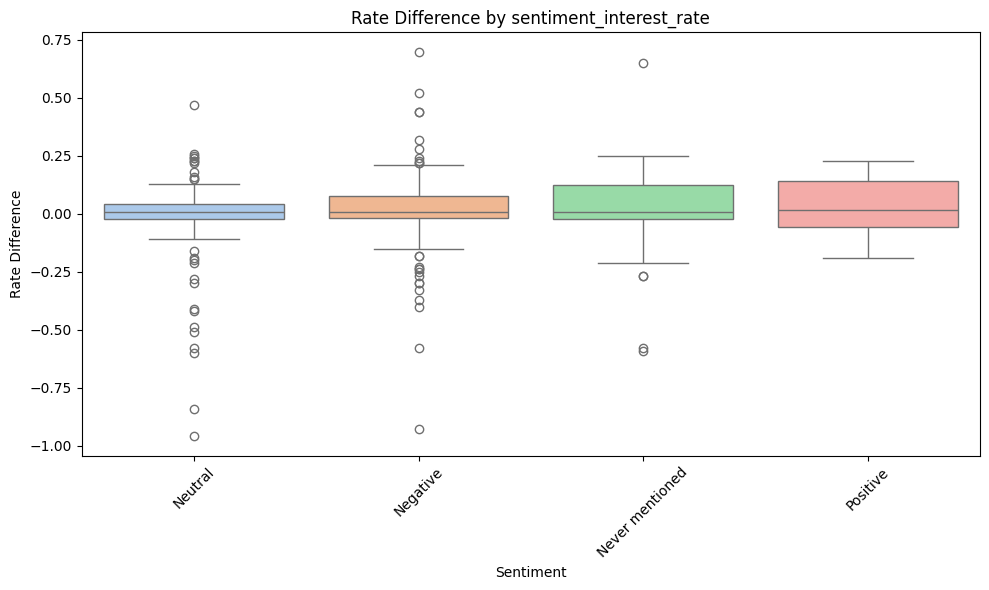

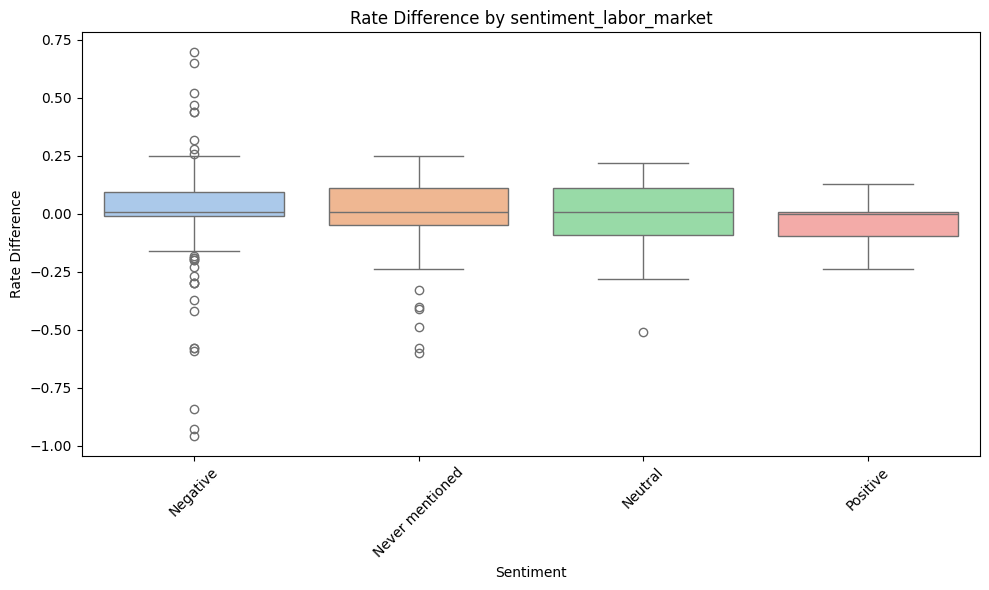

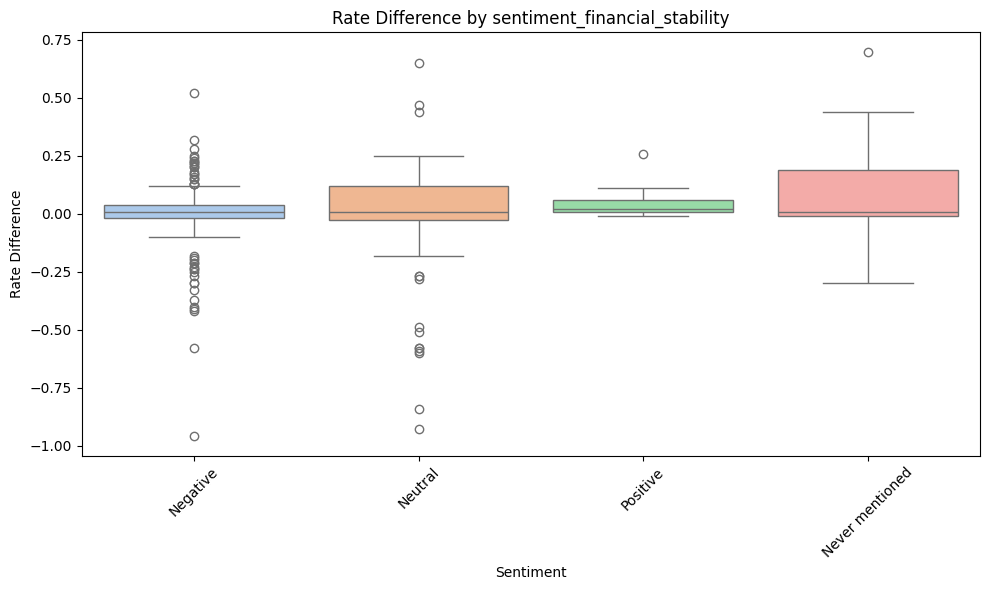

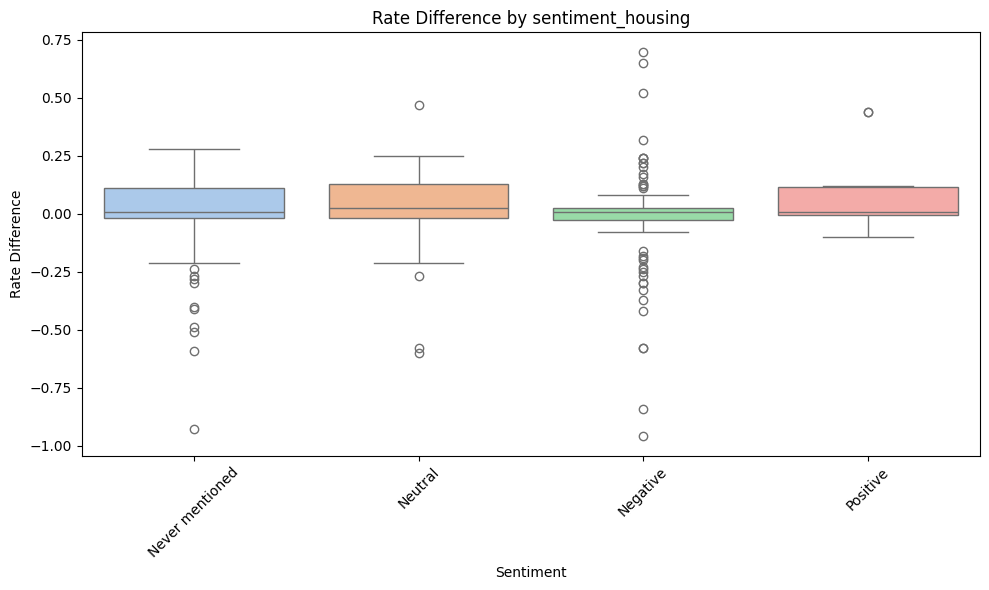

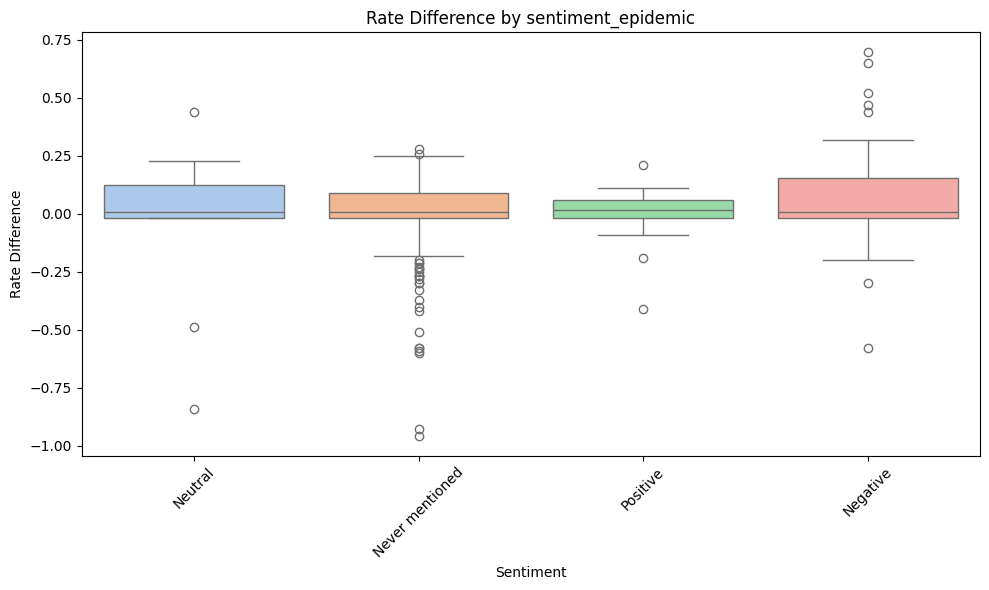

In [26]:
# plot the rate difference by sentiment for FED
sentiment_columns = [col for col in fed_agg_thirty.columns if col.startswith('sentiment_')]

for col in sentiment_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=fed_agg_thirty, x=col, y='rate_difference', hue=col, palette='pastel', legend=False)
    plt.title(f'Rate Difference by {col}')
    plt.xlabel('Sentiment')
    plt.ylabel('Rate Difference')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


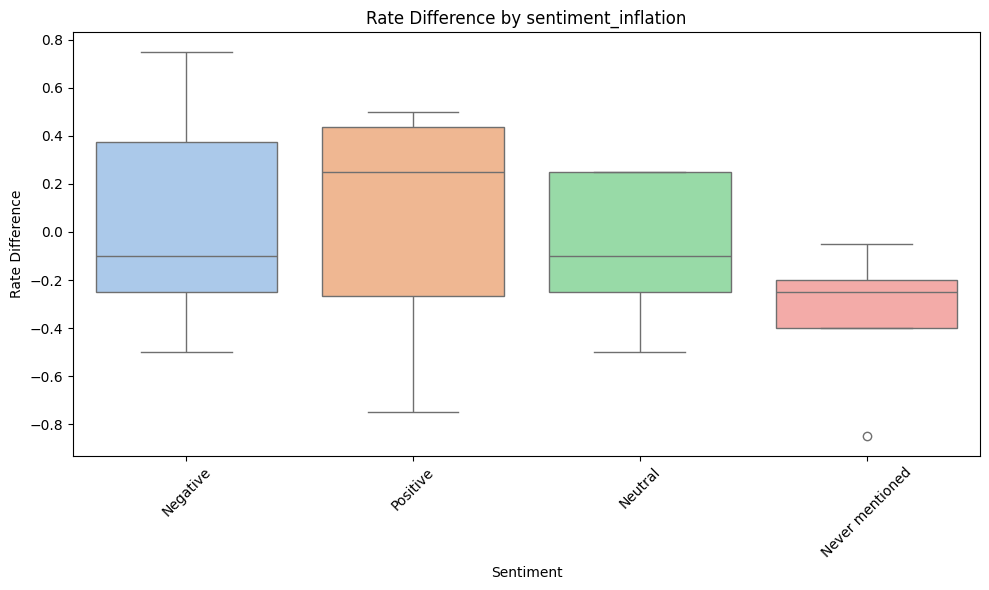

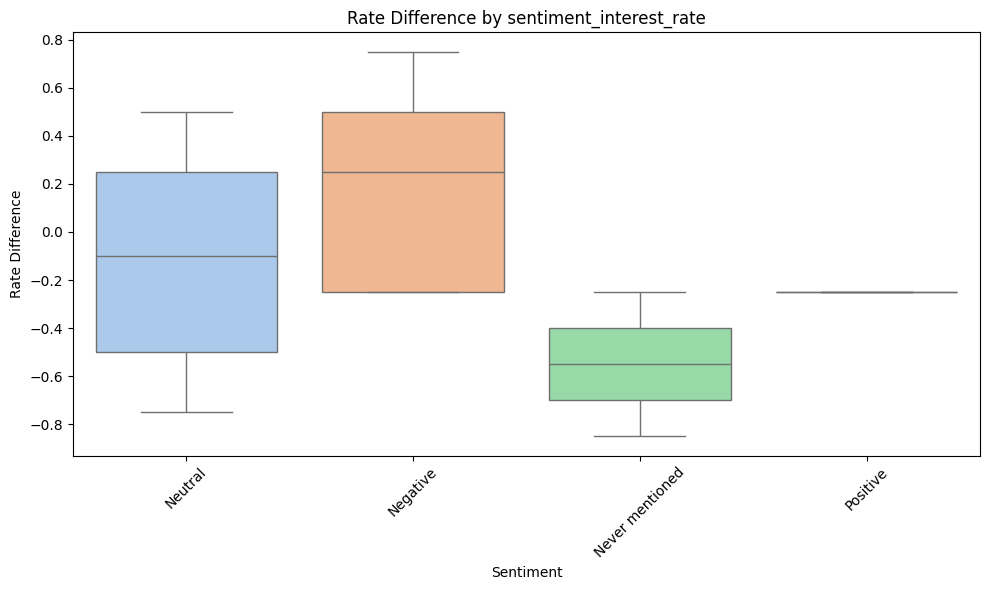

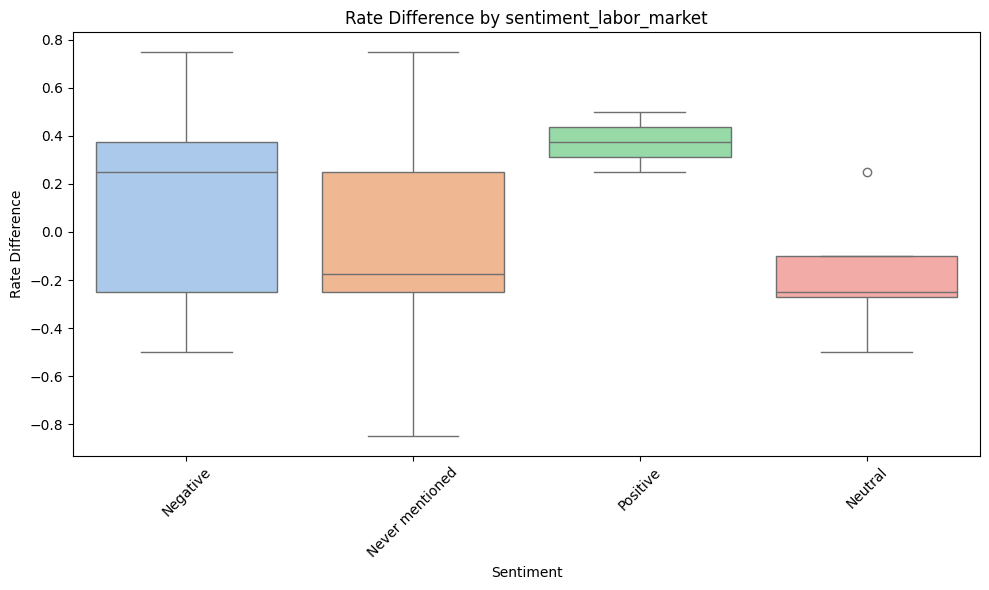

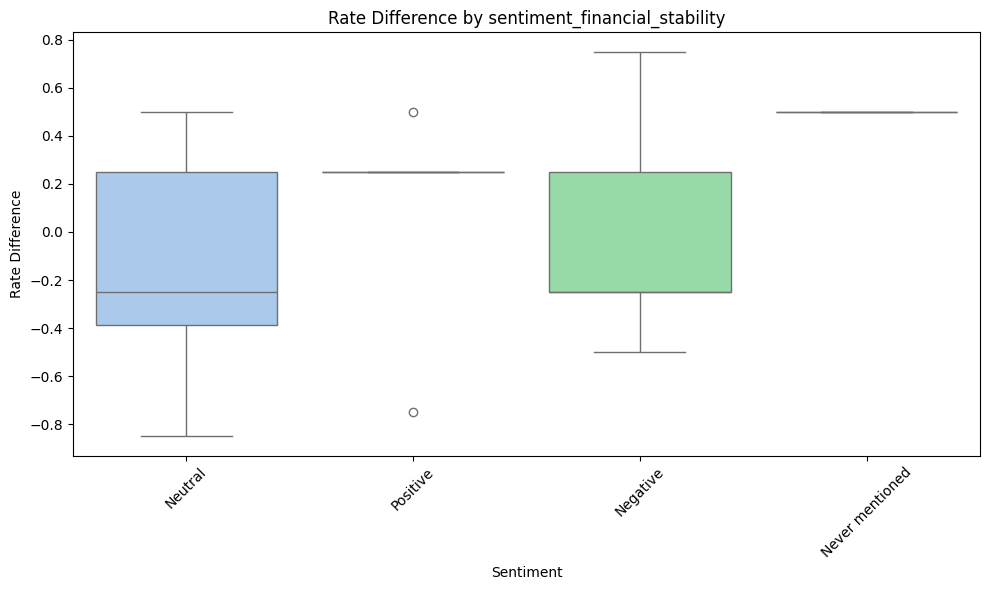

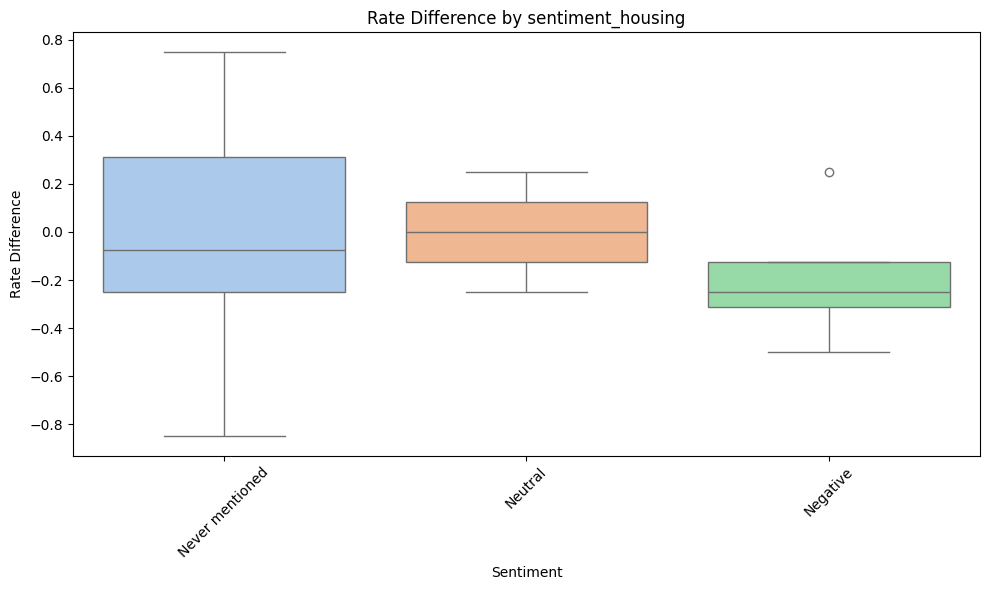

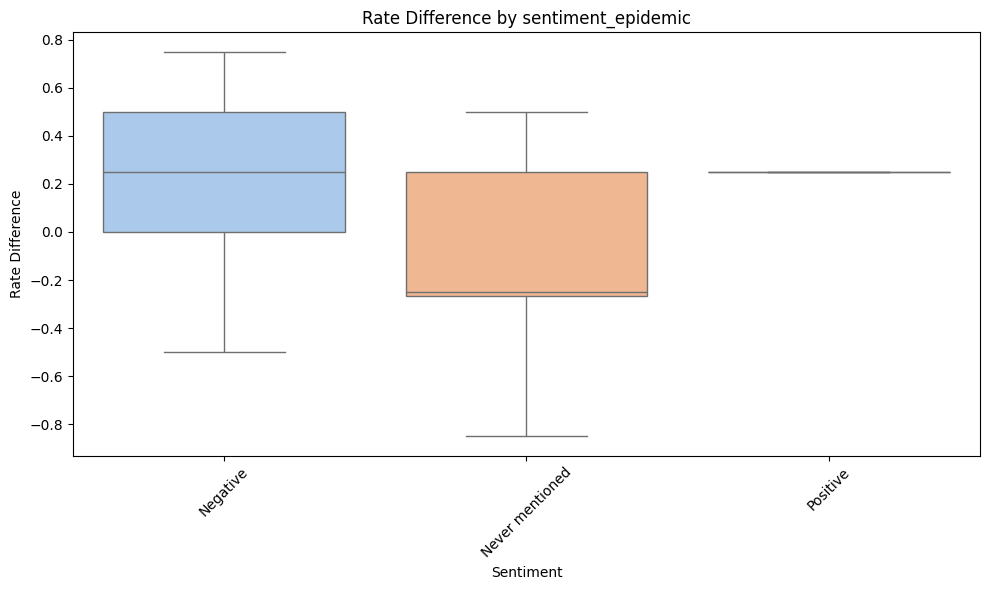

In [27]:
# plot the rate difference by sentiment for ECB
sentiment_columns = [col for col in ecb_agg_thirty.columns if col.startswith('sentiment_')]

for col in sentiment_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=ecb_agg_thirty, x=col, y='rate_difference', hue=col, palette='pastel', legend=False)
    plt.title(f'Rate Difference by {col}')
    plt.xlabel('Sentiment')
    plt.ylabel('Rate Difference')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [28]:
# Print the sentiment distribution for each aspect
print("ECB Aggregated (30 Days):")
for col in sentiment_columns:
    print(f"\n{col}:")
    print(ecb_agg_thirty[col].value_counts())

print("\nFED Aggregated (30 Days):")
for col in sentiment_columns:
    print(f"\n{col}:")
    print(fed_agg_thirty[col].value_counts())

ECB Aggregated (30 Days):

sentiment_inflation:
sentiment_inflation
Negative           19
Positive           10
Neutral             5
Never mentioned     4
Name: count, dtype: int64

sentiment_interest_rate:
sentiment_interest_rate
Neutral            19
Negative           16
Never mentioned     2
Positive            1
Name: count, dtype: int64

sentiment_labor_market:
sentiment_labor_market
Never mentioned    20
Negative           11
Neutral             5
Positive            2
Name: count, dtype: int64

sentiment_financial_stability:
sentiment_financial_stability
Negative           25
Neutral             7
Positive            5
Never mentioned     1
Name: count, dtype: int64

sentiment_housing:
sentiment_housing
Never mentioned    32
Negative            4
Neutral             2
Name: count, dtype: int64

sentiment_epidemic:
sentiment_epidemic
Never mentioned    26
Negative           11
Positive            1
Name: count, dtype: int64

FED Aggregated (30 Days):

sentiment_inflation:
senti

# Regression

## Data Preparation

In [43]:
df = pd.read_csv('data/cleaned_sentiment_data.csv')

In [44]:
from sklearn.preprocessing import OneHotEncoder

sentiment_columns = [col for col in df.columns if col.startswith('sentiment_')]
encoder = OneHotEncoder(sparse_output=False, drop='if_binary')
encoded_sentiments = encoder.fit_transform(df[sentiment_columns])
encoded_df = pd.DataFrame(encoded_sentiments, columns=encoder.get_feature_names_out(sentiment_columns))
df = pd.concat([df.drop(columns=sentiment_columns), encoded_df], axis=1)

In [45]:
ecb_df = df[df['country']== 'Euro area']
fed_df = df[df['country']== 'United States']

In [ ]:
def aggregate_pre_decision_speeches_seven(df):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['next_rate_date'] = pd.to_datetime(df['next_rate_date'])

    aggregated_rows = []

    decision_dates = df['next_rate_date'].dropna().unique()

    sentiment_count_cols = [col for col in df.columns if col.startswith('sentiment_')]

    for decision_date in decision_dates:
        mask = (df['date'] >= decision_date - pd.Timedelta(days=7)) & (df['date'] < decision_date)
        speeches = df[mask]

        if speeches.empty:
            continue

        sentiment_sums = speeches[sentiment_count_cols].sum(numeric_only=True)

        aggregated_rows.append({
            'next_rate_date': decision_date,
            'num_speeches': len(speeches),
            'rate_difference': speeches['rate_difference'].mean(),
            **sentiment_sums.to_dict()
        })

    return pd.DataFrame(aggregated_rows)


In [47]:
ecb_agg_seven = aggregate_pre_decision_speeches_seven(ecb_df)
fed_agg_seven = aggregate_pre_decision_speeches_seven(fed_df)

In [ ]:
def aggregate_pre_decision_speeches_fifteen(df):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['next_rate_date'] = pd.to_datetime(df['next_rate_date'])

    aggregated_rows = []

    decision_dates = df['next_rate_date'].dropna().unique()

    sentiment_count_cols = [col for col in df.columns if col.startswith('sentiment_')]

    for decision_date in decision_dates:
        mask = (df['date'] >= decision_date - pd.Timedelta(days=15)) & (df['date'] < decision_date)
        speeches = df[mask]

        if speeches.empty:
            continue

        sentiment_sums = speeches[sentiment_count_cols].sum(numeric_only=True)

        aggregated_rows.append({
            'next_rate_date': decision_date,
            'num_speeches': len(speeches),
            'rate_difference': speeches['rate_difference'].mean(),
            **sentiment_sums.to_dict()
        })

    return pd.DataFrame(aggregated_rows)


In [49]:
ecb_agg_fifteen = aggregate_pre_decision_speeches_fifteen(ecb_df)
fed_agg_fifteen = aggregate_pre_decision_speeches_fifteen(fed_df)

In [ ]:
def aggregate_pre_decision_speeches_thirty(df):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['next_rate_date'] = pd.to_datetime(df['next_rate_date'])

    aggregated_rows = []

    decision_dates = df['next_rate_date'].dropna().unique()

    sentiment_count_cols = [col for col in df.columns if col.startswith('sentiment_')]

    for decision_date in decision_dates:
        mask = (df['date'] >= decision_date - pd.Timedelta(days=30)) & (df['date'] < decision_date)
        speeches = df[mask]

        if speeches.empty:
            continue  
        sentiment_sums = speeches[sentiment_count_cols].sum(numeric_only=True)

        aggregated_rows.append({
            'next_rate_date': decision_date,
            'num_speeches': len(speeches),
            'rate_difference': speeches['rate_difference'].mean(),
            **sentiment_sums.to_dict()
        })

    return pd.DataFrame(aggregated_rows)


In [51]:
ecb_agg_thirty = aggregate_pre_decision_speeches_thirty(ecb_df)
fed_agg_thirty = aggregate_pre_decision_speeches_thirty(fed_df)

## 7 days

### ECB

In [54]:
X = ecb_agg_seven[['sentiment_labor_market_Negative', 'sentiment_labor_market_Neutral', 'sentiment_labor_market_Positive', 'sentiment_labor_market_Never mentioned']]
y = ecb_agg_seven['rate_difference']
X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     1.888
Date:                Sat, 24 May 2025   Prob (F-statistic):              0.142
Time:                        15:53:28   Log-Likelihood:                -14.223
No. Observations:                  32   AIC:                             38.45
Df Residuals:                      27   BIC:                             45.78
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [ ]:
X = ecb_agg_seven[['sentiment_inflation_Negative', 'sentiment_inflation_Neutral', 'sentiment_inflation_Positive', 'sentiment_inflation_Never mentioned']]
y = ecb_agg_seven['rate_difference']
X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     2.553
Date:                Sat, 24 May 2025   Prob (F-statistic):             0.0619
Time:                        15:53:32   Log-Likelihood:                -13.035
No. Observations:                  32   AIC:                             36.07
Df Residuals:                      27   BIC:                             43.40
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

In [56]:
X = ecb_agg_seven[['sentiment_interest_rate_Negative', 'sentiment_interest_rate_Neutral', 'sentiment_interest_rate_Positive', 'sentiment_interest_rate_Never mentioned']]
y = ecb_agg_seven['rate_difference']
X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     4.384
Date:                Sat, 24 May 2025   Prob (F-statistic):            0.00735
Time:                        15:53:33   Log-Likelihood:                -10.160
No. Observations:                  32   AIC:                             30.32
Df Residuals:                      27   BIC:                             37.65
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [57]:
X = ecb_agg_seven[['sentiment_financial_stability_Negative', 'sentiment_financial_stability_Neutral', 'sentiment_financial_stability_Positive', 'sentiment_financial_stability_Never mentioned']]
y = ecb_agg_seven['rate_difference']
X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     3.025
Date:                Sat, 24 May 2025   Prob (F-statistic):             0.0349
Time:                        15:53:34   Log-Likelihood:                -12.244
No. Observations:                  32   AIC:                             34.49
Df Residuals:                      27   BIC:                             41.82
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [58]:
X = ecb_agg_seven[['sentiment_housing_Negative', 'sentiment_housing_Neutral', 'sentiment_housing_Positive', 'sentiment_housing_Never mentioned']]
y = ecb_agg_seven['rate_difference']
X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     2.144
Date:                Sat, 24 May 2025   Prob (F-statistic):              0.103
Time:                        15:53:34   Log-Likelihood:                -13.755
No. Observations:                  32   AIC:                             37.51
Df Residuals:                      27   BIC:                             44.84
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [59]:
X = ecb_agg_seven[['sentiment_epidemic_Negative', 'sentiment_epidemic_Neutral', 'sentiment_epidemic_Positive', 'sentiment_epidemic_Never mentioned']]
y = ecb_agg_seven['rate_difference']
X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     4.109
Date:                Sat, 24 May 2025   Prob (F-statistic):            0.00996
Time:                        15:53:35   Log-Likelihood:                -10.561
No. Observations:                  32   AIC:                             31.12
Df Residuals:                      27   BIC:                             38.45
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

### FED

In [60]:
X = fed_agg_seven[['sentiment_labor_market_Negative', 'sentiment_labor_market_Neutral', 'sentiment_labor_market_Positive', 'sentiment_labor_market_Never mentioned']]
y = fed_agg_seven['rate_difference']
X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                    0.3168
Date:                Sat, 24 May 2025   Prob (F-statistic):              0.866
Time:                        15:53:35   Log-Likelihood:                 24.518
No. Observations:                 141   AIC:                            -39.04
Df Residuals:                     136   BIC:                            -24.29
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [61]:
X = fed_agg_seven[['sentiment_inflation_Negative', 'sentiment_inflation_Neutral', 'sentiment_inflation_Positive', 'sentiment_inflation_Never mentioned']]
y = fed_agg_seven['rate_difference']
X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                    0.1847
Date:                Sat, 24 May 2025   Prob (F-statistic):              0.946
Time:                        15:53:35   Log-Likelihood:                 24.246
No. Observations:                 141   AIC:                            -38.49
Df Residuals:                     136   BIC:                            -23.75
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

In [62]:
X = fed_agg_seven[['sentiment_interest_rate_Negative', 'sentiment_interest_rate_Neutral', 'sentiment_interest_rate_Positive', 'sentiment_interest_rate_Never mentioned']]
y = fed_agg_seven['rate_difference']
X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.6661
Date:                Sat, 24 May 2025   Prob (F-statistic):              0.617
Time:                        15:53:36   Log-Likelihood:                 25.232
No. Observations:                 141   AIC:                            -40.46
Df Residuals:                     136   BIC:                            -25.72
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [63]:
X = fed_agg_seven[['sentiment_financial_stability_Negative', 'sentiment_financial_stability_Neutral', 'sentiment_financial_stability_Positive', 'sentiment_financial_stability_Never mentioned']]
y = fed_agg_seven['rate_difference']
X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.026
Method:                 Least Squares   F-statistic:                    0.1094
Date:                Sat, 24 May 2025   Prob (F-statistic):              0.979
Time:                        15:53:36   Log-Likelihood:                 24.091
No. Observations:                 141   AIC:                            -38.18
Df Residuals:                     136   BIC:                            -23.44
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [64]:
X = fed_agg_seven[['sentiment_housing_Negative', 'sentiment_housing_Neutral', 'sentiment_housing_Positive', 'sentiment_housing_Never mentioned']]
y = fed_agg_seven['rate_difference']
X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.8138
Date:                Sat, 24 May 2025   Prob (F-statistic):              0.518
Time:                        15:53:36   Log-Likelihood:                 25.532
No. Observations:                 141   AIC:                            -41.06
Df Residuals:                     136   BIC:                            -26.32
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [65]:
X = fed_agg_seven[['sentiment_epidemic_Negative', 'sentiment_epidemic_Neutral', 'sentiment_epidemic_Positive', 'sentiment_epidemic_Never mentioned']]
y = fed_agg_seven['rate_difference']
X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.3677
Date:                Sat, 24 May 2025   Prob (F-statistic):              0.831
Time:                        15:53:36   Log-Likelihood:                 24.622
No. Observations:                 141   AIC:                            -39.24
Df Residuals:                     136   BIC:                            -24.50
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

## 15 days

### ECB

In [66]:
X = ecb_agg_fifteen[['sentiment_labor_market_Negative', 'sentiment_labor_market_Neutral', 'sentiment_labor_market_Positive', 'sentiment_labor_market_Never mentioned']]
y = ecb_agg_fifteen['rate_difference']
X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     3.686
Date:                Sat, 24 May 2025   Prob (F-statistic):             0.0144
Time:                        15:53:37   Log-Likelihood:                -12.153
No. Observations:                  36   AIC:                             34.31
Df Residuals:                      31   BIC:                             42.22
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [67]:
X = ecb_agg_fifteen[['sentiment_inflation_Negative', 'sentiment_inflation_Neutral', 'sentiment_inflation_Positive', 'sentiment_inflation_Never mentioned']]
y = ecb_agg_fifteen['rate_difference']
X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     3.625
Date:                Sat, 24 May 2025   Prob (F-statistic):             0.0155
Time:                        15:53:37   Log-Likelihood:                -12.250
No. Observations:                  36   AIC:                             34.50
Df Residuals:                      31   BIC:                             42.42
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

In [68]:
X = ecb_agg_fifteen[['sentiment_interest_rate_Negative', 'sentiment_interest_rate_Neutral', 'sentiment_interest_rate_Positive', 'sentiment_interest_rate_Never mentioned']]
y = ecb_agg_fifteen['rate_difference']
X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     4.084
Date:                Sat, 24 May 2025   Prob (F-statistic):            0.00898
Time:                        15:53:38   Log-Likelihood:                -11.538
No. Observations:                  36   AIC:                             33.08
Df Residuals:                      31   BIC:                             40.99
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [69]:
X = ecb_agg_fifteen[['sentiment_financial_stability_Negative', 'sentiment_financial_stability_Neutral', 'sentiment_financial_stability_Positive', 'sentiment_financial_stability_Never mentioned']]
y = ecb_agg_fifteen['rate_difference']
X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     3.274
Date:                Sat, 24 May 2025   Prob (F-statistic):             0.0238
Time:                        15:53:38   Log-Likelihood:                -12.815
No. Observations:                  36   AIC:                             35.63
Df Residuals:                      31   BIC:                             43.55
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [70]:
X = ecb_agg_fifteen[['sentiment_housing_Negative', 'sentiment_housing_Neutral', 'sentiment_housing_Positive', 'sentiment_housing_Never mentioned']]
y = ecb_agg_fifteen['rate_difference']
X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     3.742
Date:                Sat, 24 May 2025   Prob (F-statistic):             0.0135
Time:                        15:53:38   Log-Likelihood:                -12.065
No. Observations:                  36   AIC:                             34.13
Df Residuals:                      31   BIC:                             42.05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [71]:
X = ecb_agg_fifteen[['sentiment_epidemic_Negative', 'sentiment_epidemic_Neutral', 'sentiment_epidemic_Positive', 'sentiment_epidemic_Never mentioned']]
y = ecb_agg_fifteen['rate_difference']
X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     3.815
Date:                Sat, 24 May 2025   Prob (F-statistic):             0.0123
Time:                        15:53:38   Log-Likelihood:                -11.951
No. Observations:                  36   AIC:                             33.90
Df Residuals:                      31   BIC:                             41.82
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

### FED

In [72]:
X = fed_agg_fifteen[['sentiment_labor_market_Negative', 'sentiment_labor_market_Neutral', 'sentiment_labor_market_Positive', 'sentiment_labor_market_Never mentioned']]
y = fed_agg_fifteen['rate_difference']
X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.6102
Date:                Sat, 24 May 2025   Prob (F-statistic):              0.656
Time:                        15:53:39   Log-Likelihood:                 26.896
No. Observations:                 206   AIC:                            -43.79
Df Residuals:                     201   BIC:                            -27.15
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [73]:
X = fed_agg_fifteen[['sentiment_inflation_Negative', 'sentiment_inflation_Neutral', 'sentiment_inflation_Positive', 'sentiment_inflation_Never mentioned']]
y = fed_agg_fifteen['rate_difference']
X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.7533
Date:                Sat, 24 May 2025   Prob (F-statistic):              0.557
Time:                        15:53:40   Log-Likelihood:                 27.185
No. Observations:                 206   AIC:                            -44.37
Df Residuals:                     201   BIC:                            -27.73
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

In [74]:
X = fed_agg_fifteen[['sentiment_interest_rate_Negative', 'sentiment_interest_rate_Neutral', 'sentiment_interest_rate_Positive', 'sentiment_interest_rate_Never mentioned']]
y = fed_agg_fifteen['rate_difference']
X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.488
Date:                Sat, 24 May 2025   Prob (F-statistic):              0.207
Time:                        15:53:40   Log-Likelihood:                 28.658
No. Observations:                 206   AIC:                            -47.32
Df Residuals:                     201   BIC:                            -30.68
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [75]:
X = fed_agg_fifteen[['sentiment_financial_stability_Negative', 'sentiment_financial_stability_Neutral', 'sentiment_financial_stability_Positive', 'sentiment_financial_stability_Never mentioned']]
y = fed_agg_fifteen['rate_difference']
X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.069
Date:                Sat, 24 May 2025   Prob (F-statistic):              0.373
Time:                        15:53:40   Log-Likelihood:                 27.822
No. Observations:                 206   AIC:                            -45.64
Df Residuals:                     201   BIC:                            -29.00
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [76]:
X = fed_agg_fifteen[['sentiment_housing_Negative', 'sentiment_housing_Neutral', 'sentiment_housing_Positive', 'sentiment_housing_Never mentioned']]
y = fed_agg_fifteen['rate_difference']
X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.6078
Date:                Sat, 24 May 2025   Prob (F-statistic):              0.657
Time:                        15:53:40   Log-Likelihood:                 26.891
No. Observations:                 206   AIC:                            -43.78
Df Residuals:                     201   BIC:                            -27.14
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [77]:
X = fed_agg_fifteen[['sentiment_epidemic_Negative', 'sentiment_epidemic_Neutral', 'sentiment_epidemic_Positive', 'sentiment_epidemic_Never mentioned']]
y = fed_agg_fifteen['rate_difference']
X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.229
Date:                Sat, 24 May 2025   Prob (F-statistic):              0.300
Time:                        15:53:41   Log-Likelihood:                 28.142
No. Observations:                 206   AIC:                            -46.28
Df Residuals:                     201   BIC:                            -29.64
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

## 30 days

### ECB

In [78]:
X = ecb_agg_thirty[['sentiment_labor_market_Negative', 'sentiment_labor_market_Neutral', 'sentiment_labor_market_Positive', 'sentiment_labor_market_Never mentioned']]
y = ecb_agg_thirty['rate_difference']
X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     5.050
Date:                Sat, 24 May 2025   Prob (F-statistic):            0.00275
Time:                        15:53:42   Log-Likelihood:                -11.120
No. Observations:                  38   AIC:                             32.24
Df Residuals:                      33   BIC:                             40.43
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [79]:
X = ecb_agg_thirty[['sentiment_inflation_Negative', 'sentiment_inflation_Neutral', 'sentiment_inflation_Positive', 'sentiment_inflation_Never mentioned']]
y = ecb_agg_thirty['rate_difference']
X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     4.247
Date:                Sat, 24 May 2025   Prob (F-statistic):            0.00698
Time:                        15:53:42   Log-Likelihood:                -12.302
No. Observations:                  38   AIC:                             34.60
Df Residuals:                      33   BIC:                             42.79
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

In [80]:
X = ecb_agg_thirty[['sentiment_interest_rate_Negative', 'sentiment_interest_rate_Neutral', 'sentiment_interest_rate_Positive', 'sentiment_interest_rate_Never mentioned']]
y = ecb_agg_thirty['rate_difference']
X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     4.853
Date:                Sat, 24 May 2025   Prob (F-statistic):            0.00344
Time:                        15:53:42   Log-Likelihood:                -11.402
No. Observations:                  38   AIC:                             32.80
Df Residuals:                      33   BIC:                             40.99
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [81]:
X = ecb_agg_thirty[['sentiment_financial_stability_Negative', 'sentiment_financial_stability_Neutral', 'sentiment_financial_stability_Positive', 'sentiment_financial_stability_Never mentioned']]
y = ecb_agg_thirty['rate_difference']
X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     4.386
Date:                Sat, 24 May 2025   Prob (F-statistic):            0.00593
Time:                        15:53:42   Log-Likelihood:                -12.092
No. Observations:                  38   AIC:                             34.18
Df Residuals:                      33   BIC:                             42.37
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [82]:
X = ecb_agg_thirty[['sentiment_housing_Negative', 'sentiment_housing_Neutral', 'sentiment_housing_Positive', 'sentiment_housing_Never mentioned']]
y = ecb_agg_thirty['rate_difference']
X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     4.888
Date:                Sat, 24 May 2025   Prob (F-statistic):            0.00331
Time:                        15:53:43   Log-Likelihood:                -11.352
No. Observations:                  38   AIC:                             32.70
Df Residuals:                      33   BIC:                             40.89
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [83]:
X = ecb_agg_thirty[['sentiment_epidemic_Negative', 'sentiment_epidemic_Neutral', 'sentiment_epidemic_Positive', 'sentiment_epidemic_Never mentioned']]
y = ecb_agg_thirty['rate_difference']
X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     4.601
Date:                Sat, 24 May 2025   Prob (F-statistic):            0.00461
Time:                        15:53:43   Log-Likelihood:                -11.772
No. Observations:                  38   AIC:                             33.54
Df Residuals:                      33   BIC:                             41.73
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

### FED

In [84]:
X = fed_agg_thirty[['sentiment_labor_market_Negative', 'sentiment_labor_market_Neutral', 'sentiment_labor_market_Positive', 'sentiment_labor_market_Never mentioned']]
y = fed_agg_thirty['rate_difference']
X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.111
Date:                Sat, 24 May 2025   Prob (F-statistic):              0.352
Time:                        15:53:43   Log-Likelihood:                 35.337
No. Observations:                 235   AIC:                            -60.67
Df Residuals:                     230   BIC:                            -43.38
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [85]:
X = fed_agg_thirty[['sentiment_inflation_Negative', 'sentiment_inflation_Neutral', 'sentiment_inflation_Positive', 'sentiment_inflation_Never mentioned']]
y = fed_agg_thirty['rate_difference']
X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.8624
Date:                Sat, 24 May 2025   Prob (F-statistic):              0.487
Time:                        15:53:44   Log-Likelihood:                 34.836
No. Observations:                 235   AIC:                            -59.67
Df Residuals:                     230   BIC:                            -42.37
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

In [86]:
X = fed_agg_thirty[['sentiment_interest_rate_Negative', 'sentiment_interest_rate_Neutral', 'sentiment_interest_rate_Positive', 'sentiment_interest_rate_Never mentioned']]
y = fed_agg_thirty['rate_difference']
X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.978
Date:                Sat, 24 May 2025   Prob (F-statistic):             0.0988
Time:                        15:53:44   Log-Likelihood:                 37.060
No. Observations:                 235   AIC:                            -64.12
Df Residuals:                     230   BIC:                            -46.82
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [87]:
X = fed_agg_thirty[['sentiment_financial_stability_Negative', 'sentiment_financial_stability_Neutral', 'sentiment_financial_stability_Positive', 'sentiment_financial_stability_Never mentioned']]
y = fed_agg_thirty['rate_difference']
X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     2.356
Date:                Sat, 24 May 2025   Prob (F-statistic):             0.0546
Time:                        15:53:44   Log-Likelihood:                 37.805
No. Observations:                 235   AIC:                            -65.61
Df Residuals:                     230   BIC:                            -48.31
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [88]:
X = fed_agg_thirty[['sentiment_housing_Negative', 'sentiment_housing_Neutral', 'sentiment_housing_Positive', 'sentiment_housing_Never mentioned']]
y = fed_agg_thirty['rate_difference']
X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.187
Date:                Sat, 24 May 2025   Prob (F-statistic):              0.317
Time:                        15:53:44   Log-Likelihood:                 35.489
No. Observations:                 235   AIC:                            -60.98
Df Residuals:                     230   BIC:                            -43.68
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [89]:
X = fed_agg_thirty[['sentiment_epidemic_Negative', 'sentiment_epidemic_Neutral', 'sentiment_epidemic_Positive', 'sentiment_epidemic_Never mentioned']]
y = fed_agg_thirty['rate_difference']
X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.495
Date:                Sat, 24 May 2025   Prob (F-statistic):              0.205
Time:                        15:53:44   Log-Likelihood:                 36.103
No. Observations:                 235   AIC:                            -62.21
Df Residuals:                     230   BIC:                            -44.91
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

## Grouped sentiment

In [90]:
def add_sentiment_totals(df):
    df = df.copy()

    df['total_negative'] = df.filter(like='_Negative').sum(axis=1)
    df['total_positive'] = df.filter(like='_Positive').sum(axis=1)
    df['total_neutral'] = df.filter(like='_Neutral').sum(axis=1)
    df['total_never_mentioned'] = df.filter(like='Never mentioned').sum(axis=1)

    return df

In [91]:
ecb_thirty = add_sentiment_totals(ecb_agg_thirty)
fed_thirty = add_sentiment_totals(fed_agg_thirty)
ecb_fifteen = add_sentiment_totals(ecb_agg_fifteen)
fed_fifteen = add_sentiment_totals(fed_agg_fifteen)
ecb_seven = add_sentiment_totals(ecb_agg_seven)
fed_seven = add_sentiment_totals(fed_agg_seven)

In [ ]:
X = ecb_seven[['total_negative', 'total_positive', 'total_neutral', 'total_never_mentioned']]
y = ecb_seven['rate_difference']
X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     3.268
Date:                Sat, 24 May 2025   Prob (F-statistic):             0.0262
Time:                        15:53:46   Log-Likelihood:                -11.851
No. Observations:                  32   AIC:                             33.70
Df Residuals:                      27   BIC:                             41.03
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.26

In [ ]:
X = fed_seven[['total_negative', 'total_positive', 'total_neutral', 'total_never_mentioned']]
y = fed_seven['rate_difference']
X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.026
Method:                 Least Squares   F-statistic:                    0.1295
Date:                Sat, 24 May 2025   Prob (F-statistic):              0.971
Time:                        15:53:46   Log-Likelihood:                 24.132
No. Observations:                 141   AIC:                            -38.26
Df Residuals:                     136   BIC:                            -23.52
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.01

In [ ]:
X = ecb_fifteen[['total_negative', 'total_positive', 'total_neutral', 'total_never_mentioned']]
y = ecb_fifteen['rate_difference']
X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     4.276
Date:                Sat, 24 May 2025   Prob (F-statistic):            0.00718
Time:                        15:53:46   Log-Likelihood:                -11.248
No. Observations:                  36   AIC:                             32.50
Df Residuals:                      31   BIC:                             40.41
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.37

In [ ]:
X = fed_fifteen[['total_negative', 'total_positive', 'total_neutral', 'total_never_mentioned']]
y = fed_fifteen['rate_difference']
X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.4382
Date:                Sat, 24 May 2025   Prob (F-statistic):              0.781
Time:                        15:53:47   Log-Likelihood:                 26.547
No. Observations:                 206   AIC:                            -43.09
Df Residuals:                     201   BIC:                            -26.45
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.02

In [ ]:
X = ecb_thirty[['total_negative', 'total_positive', 'total_neutral', 'total_never_mentioned']]
y = ecb_thirty['rate_difference']
X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     5.127
Date:                Sat, 24 May 2025   Prob (F-statistic):            0.00252
Time:                        15:53:47   Log-Likelihood:                -11.010
No. Observations:                  38   AIC:                             32.02
Df Residuals:                      33   BIC:                             40.21
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.33

In [ ]:
X = fed_thirty[['total_negative', 'total_positive', 'total_neutral', 'total_never_mentioned']]
y = fed_thirty['rate_difference']
X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rate_difference   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.079
Date:                Sat, 24 May 2025   Prob (F-statistic):              0.368
Time:                        15:53:48   Log-Likelihood:                 35.272
No. Observations:                 235   AIC:                            -60.54
Df Residuals:                     230   BIC:                            -43.25
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.02